### Context
Here we try to create an algorithm to maximise profit across the S&P500. This version of the model will only take use signals derived from historical prices as found in the data, `sp500.csv`. Here we add all imports and download the data:

In [1]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta

In [2]:
# Define ticker and timeframe
ticker = "^GSPC"
start_date = "1950-01-03"
end_date = datetime.today().strftime('%Y-%m-%d')

# Download and save to CSV
sp500 = yf.download(ticker, start=start_date, end=end_date)
sp500.to_csv("sp500_data.csv")
print("Saved to sp500_data.csv")
print(sp500.head())

/var/folders/t5/x93h4kds34110n67wlm59khw0000gn/T/ipykernel_44869/2367403757.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  sp500 = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

Saved to sp500_data.csv
Price       Close   High    Low   Open   Volume
Ticker      ^GSPC  ^GSPC  ^GSPC  ^GSPC    ^GSPC
Date                                           
1950-01-03  16.66  16.66  16.66  16.66  1260000
1950-01-04  16.85  16.85  16.85  16.85  1890000
1950-01-05  16.93  16.93  16.93  16.93  2550000
1950-01-06  16.98  16.98  16.98  16.98  2010000
1950-01-09  17.08  17.08  17.08  17.08  2520000


Here we load the dataframe and parse as necessary:

In [3]:
# Load the CSV
columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
df = pd.read_csv("sp500_data.csv", skiprows=3, names=columns)

# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as index
df.set_index('Date', inplace=True)

# Display the first few rows
print(df.head())

            Close   High    Low   Open   Volume
Date                                           
1950-01-03  16.66  16.66  16.66  16.66  1260000
1950-01-04  16.85  16.85  16.85  16.85  1890000
1950-01-05  16.93  16.93  16.93  16.93  2550000
1950-01-06  16.98  16.98  16.98  16.98  2010000
1950-01-09  17.08  17.08  17.08  17.08  2520000


At this point we want to think about the signals that we want to use for our algorithm. Let us just define some of the more basic columns, such as `Daily Return` and `Cumulative Returns`.

In [4]:
def calculate_metrics(df):
    """
    Calculate financial metrics from the DataFrame.
    """
    df['Daily Return'] = df['Close'].pct_change()
    df['Log Return'] = np.log(df['Close'] / df['Close'].shift(1))
    df['Cumulative Returns'] = (1 + df['Daily Return']).cumprod() - 1
    df['Volatility'] = df['Log Return'].rolling(window=30).std()
    
    df.dropna(inplace=True)  # Drop rows with NaN values
    
    return df


Let us take a look at `Cumulative Returns` of the S&P 500 across the years (let's just take from 20 years ago)

In [5]:
end = datetime.today().strftime('%Y-%m-%d')
start = (datetime.today() - timedelta(days=365 * 20)).strftime('%Y-%m-%d')  # 20 years ago

In [6]:
import matplotlib.pyplot as plt

def plot_cumulative_returns(df, start=None, end=None):
    """
    Plots cumulative returns of S&P 500 between optional start and end dates.

    Parameters:
    - df: DataFrame with a DateTime index and a column named 'Cumulative Returns'
    - start: str or datetime (optional), start date for slicing
    - end: str or datetime (optional), end date for slicing
    """
    # Ensure index is datetime
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Apply date filtering
    if start or end:
        df = df.loc[start:end]

    # Calculate metrics from scratch
    df = calculate_metrics(df)

    plt.figure(figsize=(14, 7))
    plt.plot(df['Cumulative Returns'], label='Cumulative Returns')
    plt.title('Cumulative Returns of S&P 500')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Returns')
    plt.legend()
    plt.grid(True)
    plt.show()


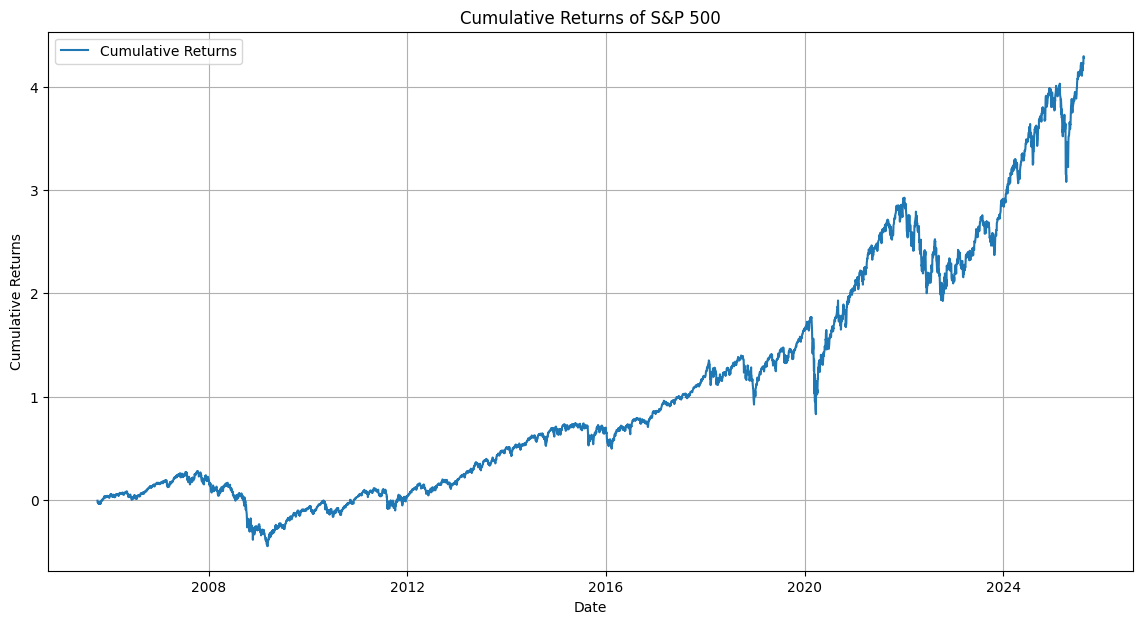

In [7]:
plot_cumulative_returns(df, start=start, end=end)


Now, let's take a look at the run-up and drawdown graphs:

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

def calculate_drawdown_and_runup(df, threshold=-0.20):
    """
    Calculate drawdown and run-up from the DataFrame with 'Cumulative Returns'.
    
    Parameters:
    - df: DataFrame with DateTime index and 'Cumulative Returns' column
    - threshold: float, reset threshold for run-up (default: -0.20 for 20% drawdown)
    
    Returns:
    - df: DataFrame with 'Drawdown' and 'Run-up' columns added
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Calculate metrics from scratch
    df = calculate_metrics(df)

    # Drawdown calculation
    df['Drawdown'] = df['Cumulative Returns'] - df['Cumulative Returns'].cummax()

    # Run-up logic
    run_up = []
    current_base = df['Cumulative Returns'].iloc[0]
    
    for i in range(len(df)):
        if df['Drawdown'].iloc[i] <= threshold:
            current_base = df['Cumulative Returns'].iloc[i]
        
        run_up_val = df['Cumulative Returns'].iloc[i] - current_base
        run_up.append(run_up_val)
    
    df['Run-up'] = run_up

    return df

def plot_drawdown_and_runup(df, threshold=-0.20, start=None, end=None):
    """
    Plots drawdown and run-up for a given DataFrame with a 'Cumulative Returns' column.
    
    Parameters:
    - df: DataFrame with DateTime index and 'Cumulative Returns' column
    - threshold: float, reset threshold for run-up (default: -0.20 for 20% drawdown)
    - start: str or datetime (optional), start date to filter
    - end: str or datetime (optional), end date to filter
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    if start or end:
        df = df.loc[start:end]

    # Calculate metrics from scratch
    df = calculate_metrics(df)

    # Drawdown & Run-up calculation
    df = calculate_drawdown_and_runup(df, threshold)

    # Plot
    fig, axs = plt.subplots(2, 1, figsize=(14, 6), sharex=True)

    axs[0].plot(df.index, df['Drawdown'], color='red', label='Drawdown')
    axs[0].set_title('Drawdown of S&P 500')
    axs[0].set_ylabel('Drawdown')
    axs[0].legend()
    axs[0].grid(True)

    axs[1].plot(df.index, df['Run-up'], color='green', label='Run-up')
    axs[1].set_title(f'Run-up Periods (Resets When Drawdown ≤ {threshold*100:.0f}%)')
    axs[1].set_xlabel('Date')
    axs[1].set_ylabel('Run-up')
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()


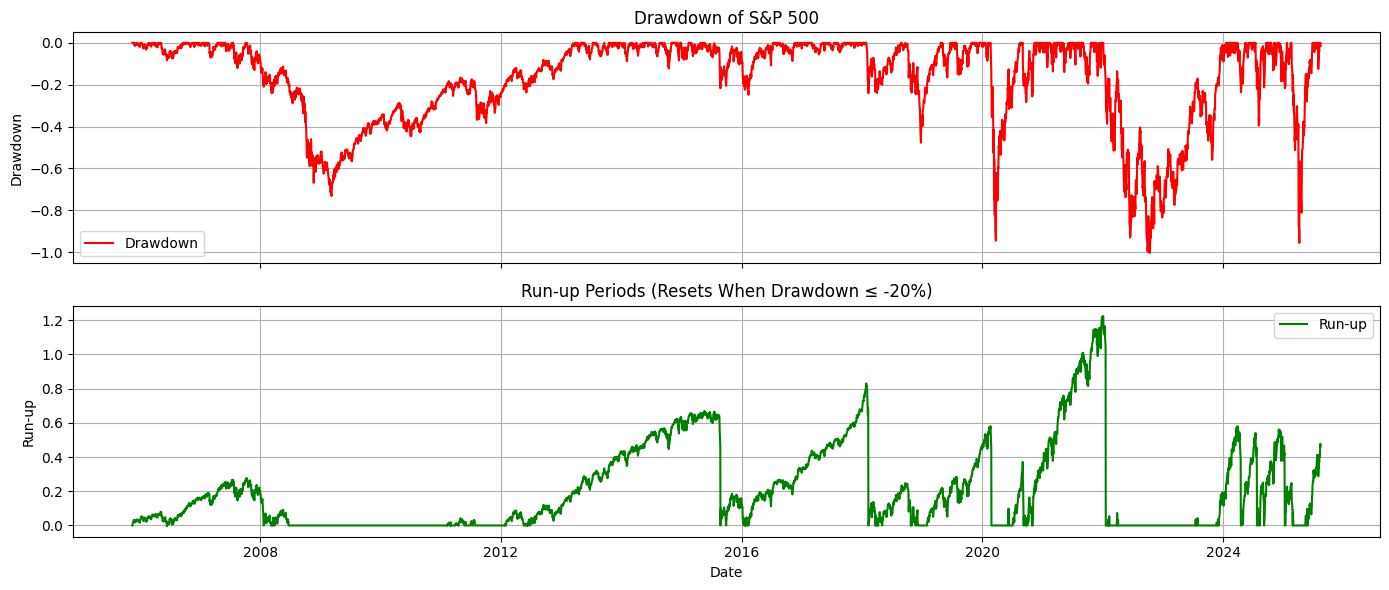

In [9]:
plot_drawdown_and_runup(df, threshold=-0.20, start=start, end=end)

This data isn't particularly significant by itself, and it'd be helpful to look at the data in relation to market regimes and cumulative returns. 

To categorise the historical data into the different regimes (bull, bear), we can either use the official definitions (drawdown <= -20% for bear start, run-up >= 20% for bull start) or try to classify them using statistical methods. Here, I'll opt to classify the data via hidden markov models (HMM). 

In [10]:
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
import numpy as np
import pandas as pd

def detect_market_regimes(df, features=['Log Return', 'Volatility'], n_components=3, random_state=42):
    """
    Fits a Gaussian HMM to specified features and assigns market regimes.

    Parameters:
    - df: pandas DataFrame containing the required features and 'Cumulative Returns'
    - features: list of column names to use as features for HMM (default: ['Log Return', 'Volatility'])
    - n_components: number of hidden states/regimes (default: 3)
    - random_state: random seed for reproducibility

    Returns:
    - df_result: DataFrame with a new 'Regime' column assigned
    - model: trained HMM model
    """
    df = calculate_metrics(df)  # Ensure metrics are calculated
    df_result = df.dropna().copy()

    # Standardize features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(df_result[features].values)

    # Fit Gaussian HMM
    model = GaussianHMM(n_components=n_components, covariance_type='full',
                        n_iter=1000, random_state=random_state)
    model.fit(X_scaled)

    # Predict regimes
    df_result['Regime'] = model.predict(X_scaled)

    # Print regime summary
    for i in range(n_components):
        mask = df_result['Regime'] == i
        mean_ret = df_result.loc[mask, 'Log Return'].mean()
        vol = df_result.loc[mask, 'Log Return'].std()
        print(f"Regime {i}: Mean Return = {mean_ret:.5f}, Volatility = {vol:.5f}")

    return df_result, model


In [11]:
detect_market_regimes(df, features=['Log Return', 'Volatility'], n_components=3)

Regime 0: Mean Return = 0.00037, Volatility = 0.00539
Regime 1: Mean Return = 0.00033, Volatility = 0.00845
Regime 2: Mean Return = 0.00017, Volatility = 0.01718


(                  Close         High          Low         Open      Volume  \
 Date                                                                         
 1950-02-15    17.059999    17.059999    17.059999    17.059999     1730000   
 1950-02-16    16.990000    16.990000    16.990000    16.990000     1920000   
 1950-02-17    17.150000    17.150000    17.150000    17.150000     1940000   
 1950-02-20    17.200001    17.200001    17.200001    17.200001     1420000   
 1950-02-21    17.170000    17.170000    17.170000    17.170000     1260000   
 ...                 ...          ...          ...          ...         ...   
 2025-08-11  6373.450195  6407.250000  6364.060059  6389.669922  4652400000   
 2025-08-12  6445.759766  6446.549805  6385.759766  6395.169922  5135300000   
 2025-08-13  6466.580078  6480.279785  6445.020020  6462.669922  5195950000   
 2025-08-14  6468.540039  6473.919922  6441.069824  6453.459961  4462050000   
 2025-08-15  6449.799805  6481.339844  6441.850098  

Given the above hidden states, we can deduce that `Regime 2` is **a bear market**, since it is the only regime with a negative mean return. It also has a high volatility, indicating market uncertainty characteristic of a bear market.

Given that `Regime 1` has a slightly higher mean return and a significantly lower volatility compared to `Regime 0`, it is more likely to be **a bull market** as it is characteristic with the high confidence in the market. It is expected that `Regime 0`, being **a neutral market**, would still have a positive mean return since stock prices always tend to increase, and the higher volatility than the bull regime still suggests investor indecision and macro noise.

In [12]:
def plot_regime_analysis(df, start=None, end=None, features=['Log Return', 'Volatility'], n_components=3, regime_colors=None):
    """
    Detects HMM market regimes and plots:
    - Cumulative returns with regime shading
    - Cumulative returns + drawdown + run-up (with same shading)
    """
    # Filter date range
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    if start or end:
        df = df.loc[start:end]

    # Detect regimes using HMM
    df_plot, _ = detect_market_regimes(df, features=features, n_components=n_components)
    df_plot = calculate_drawdown_and_runup(df_plot, threshold=-0.20)

    # Assign colors based on regime statistics
    regime_stats = []
    for i in range(n_components):
        mask = df_plot['Regime'] == i
        mean_ret = df_plot.loc[mask, 'Log Return'].mean()
        vol = df_plot.loc[mask, 'Log Return'].std()
        regime_stats.append({'regime': i, 'mean_ret': mean_ret, 'vol': vol})

    # Sort regimes: lowest return/highest vol is red, highest return/lowest vol is green, others grey
    sorted_stats = sorted(regime_stats, key=lambda x: (x['mean_ret'], -x['vol']))
    colors = {}
    if n_components == 2:
        # Red: lower return/higher vol, Green: higher return/lower vol
        colors[sorted_stats[0]['regime']] = 'red'
        colors[sorted_stats[1]['regime']] = 'green'
    elif n_components == 3:
        # Red: lowest return/highest vol, Green: highest return/lower vol, Grey: middle
        colors[sorted_stats[0]['regime']] = 'red'
        colors[sorted_stats[2]['regime']] = 'green'
        colors[sorted_stats[1]['regime']] = 'grey'
    else:
        # Default to grey for all
        for stat in sorted_stats:
            colors[stat['regime']] = 'grey'

    regime_colors = colors

    # Prepare plot
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10), sharex=True, gridspec_kw={'height_ratios': [1, 1]})

    # === Top: Cumulative Returns with regime shading ===
    ax1.plot(df_plot.index, df_plot['Cumulative Returns'], color='blue', label='Cumulative Returns')
    ax1.set_ylabel("Cumulative Returns")
    ax1.set_title("Cumulative Returns with HMM Regime Shading")
    ax1.grid(True)

    current_regime = None
    start_date = None
    for date, regime in zip(df_plot.index, df_plot['Regime']):
        if regime != current_regime:
            if current_regime is not None:
                ax1.axvspan(start_date, date, color=regime_colors.get(current_regime, 'grey'), alpha=0.2)
            current_regime = regime
            start_date = date
    ax1.axvspan(start_date, df_plot.index[-1], color=regime_colors.get(current_regime, 'grey'), alpha=0.2)

    # === Bottom: Same with Drawdown and Run-up ===
    ax2.plot(df_plot.index, df_plot['Cumulative Returns'], color='blue', label='Cumulative Returns')
    ax2.set_ylabel("Cumulative Returns")
    ax2.set_title("Cumulative Returns with Drawdown/Run-up and Regime Shading")
    ax2.grid(True)

    current_regime = None
    start_date = None
    for date, regime in zip(df_plot.index, df_plot['Regime']):
        if regime != current_regime:
            if current_regime is not None:
                ax2.axvspan(start_date, date, color=regime_colors.get(current_regime, 'grey'), alpha=0.2)
            current_regime = regime
            start_date = date
    ax2.axvspan(start_date, df_plot.index[-1], color=regime_colors.get(current_regime, 'grey'), alpha=0.2)

    # Secondary axis for drawdown/run-up
    ax2b = ax2.twinx()
    ax2b.plot(df_plot.index, df_plot.loc[df_plot.index, 'Drawdown'], color='red', label='Drawdown', alpha=0.5)
    ax2b.plot(df_plot.index, df_plot.loc[df_plot.index, 'Run-up'], color='green', label='Run-up', alpha=0.5)
    ax2b.set_ylabel("Drawdown / Run-up")
    ax2b.legend(loc='upper left')

    fig.align_ylabels()
    plt.tight_layout()
    plt.show()

Regime 0: Mean Return = 0.00051, Volatility = 0.00917
Regime 1: Mean Return = 0.00059, Volatility = 0.00570
Regime 2: Mean Return = -0.00035, Volatility = 0.02104


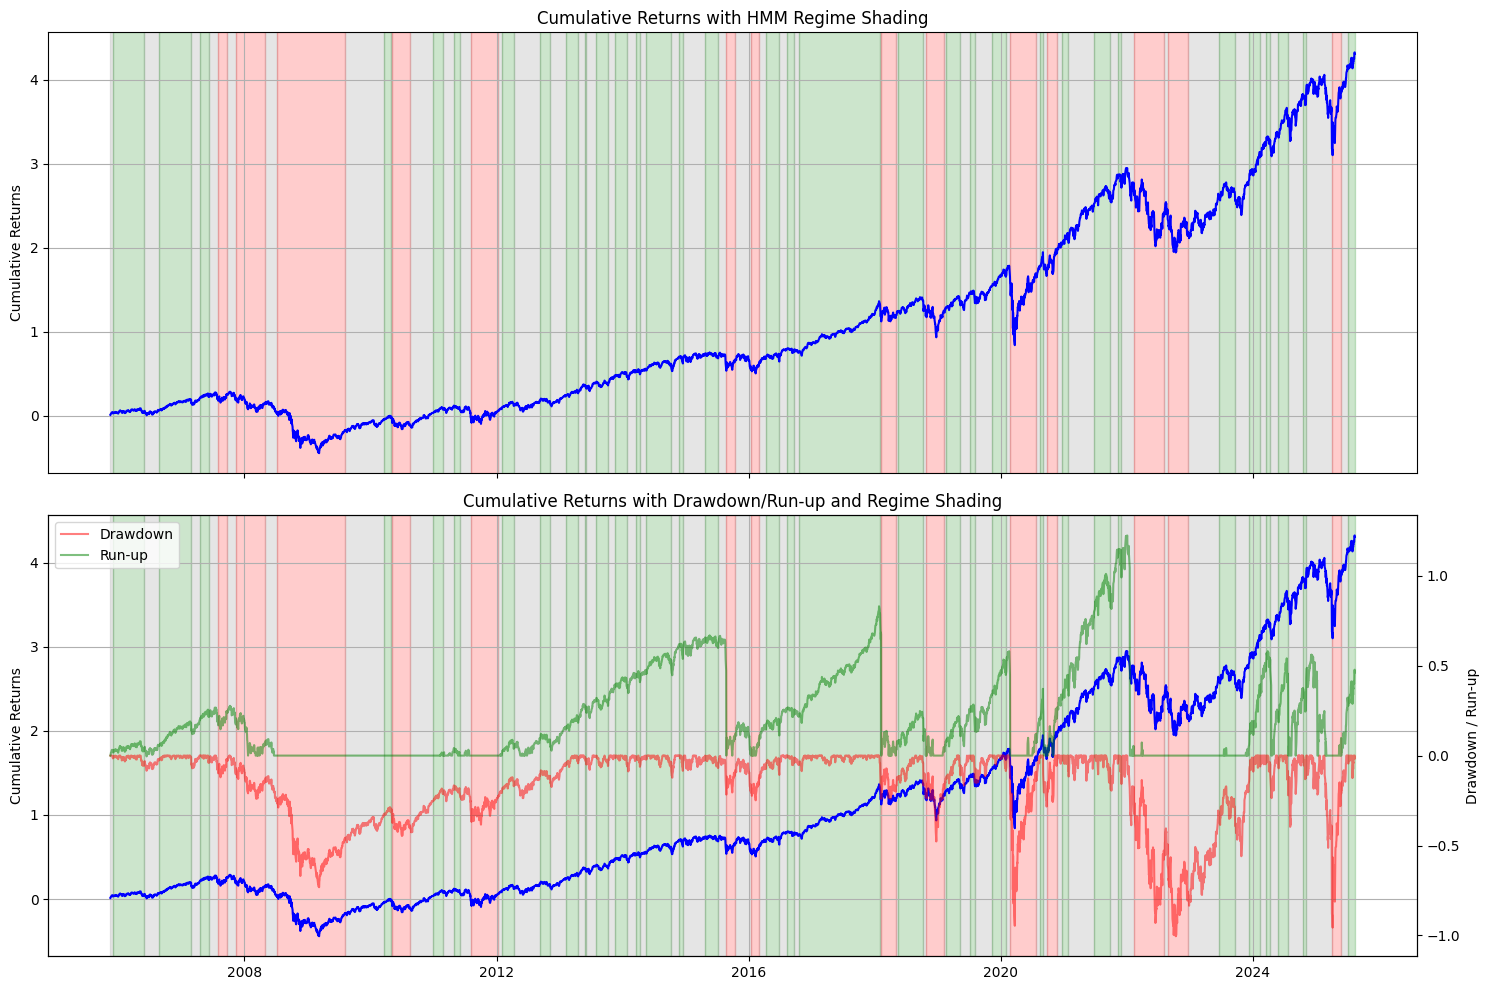

In [13]:
plot_regime_analysis(df, start=start, end=end)

Having obtained these graphs, we can see the intuitive relationship between how prices correlate to the different market regimes. What we're more interested in now is trying to predict market regimes.

Market regimes directly reflect investor confidence, hence to predict market regime changes ahead of time, we can look at proxies for investor confidence, or even looking out for signals that would impact investor confidence.

There's a lot we can do for that, but the first thing that comes to mind would be to track financial news. 

This is probably the simplest metric we can use. We try to set up **Google Cloud** to use GDELT.

Since GDELT 2.0 is only available from February 19, 2015, we set that as our start date for now (~10 years). Let's revisit the regime graph:

In [14]:
start = "2015-02-19"
end = datetime.today().strftime('%Y-%m-%d')

Regime 0: Mean Return = 0.00071, Volatility = 0.00806
Regime 1: Mean Return = 0.00061, Volatility = 0.00500
Regime 2: Mean Return = 0.00005, Volatility = 0.01676


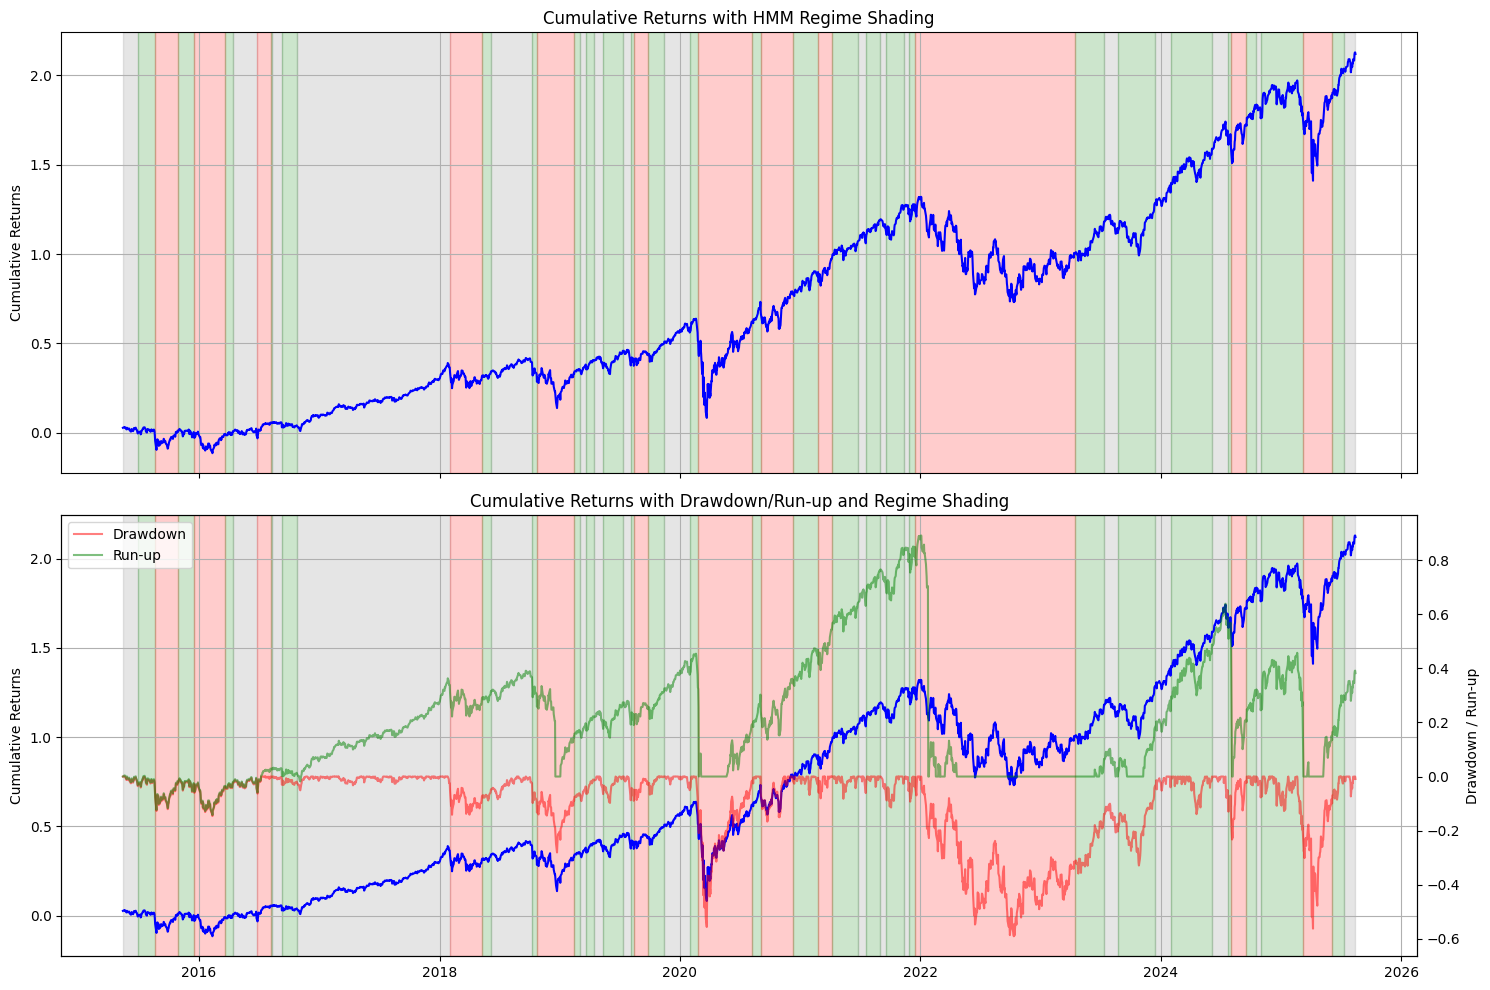

In [15]:
plot_regime_analysis(df, start=start, end=end)

With Cloud services, we always run the risk of accidentally exceeding the limit for free-tier services and incurring unintended costs. In a previous project, I manually monitored the usage of the Google Places API. In this project, I wanted to implement a script to automate billing cutoff when the budget is exceeded.

I implemented this in `budget-auto-disable`, using a **Cloud Run Function**, **Pub/Sub** and **Google Cloud Budgets**. Unfortunately, I wrote GDELC instead of GDELT for all the names inside the project, so that's what we will run with.

I initially followed https://cloud.google.com/billing/docs/how-to/disable-billing-with-notifications and the associated guides, but there were a lot of issues and the guide seemed relatively outdated, so I modified a lot of the functions with guidance from ChatGPT. We now proceed to query the necessary data from **GDELT 2.0 + GKG**:

In [16]:
from google.cloud import bigquery
from google.oauth2 import service_account

# Path to your service account JSON
key_path = "service-account.json"

# Create credentials and BigQuery client
credentials = service_account.Credentials.from_service_account_file(key_path)
client = bigquery.Client(credentials=credentials, project=credentials.project_id)

# Note: Only records from February 19, 2015 are available in the GDELT 2.0 file format

print(f"Using project: {client.project}")


Using project: gdelc-queries


In [17]:
from google.cloud import bigquery
import pandas as pd

def fetch_bulk_gkg_sentiment(start_date: str, end_date: str, themes=None, credentials=None):
    if themes is None:
        themes = [
            "ECON_STOCKMARKET", "UNEMPLOYMENT", "INFLATION", "INTEREST_RATES", "RECESSION",
            "CURRENCY", "ECON_FINANCIALCRISIS", "BANKRUPTCY", "COMMODITIES", "GDP"
        ]

    client = bigquery.Client(credentials=credentials, project=credentials.project_id if credentials else None)
    theme_filter = ' OR '.join([f'LOWER(Themes) LIKE "%{theme.lower()}%"' for theme in themes])

    query = f"""
    SELECT
        date,
        AVG(SAFE_CAST(SPLIT(V2Tone, ',')[OFFSET(0)] AS FLOAT64)) AS avg_tone,
        STDDEV(SAFE_CAST(SPLIT(V2Tone, ',')[OFFSET(0)] AS FLOAT64)) AS std_tone,
        COUNT(*) AS article_count
    FROM (
        SELECT
            PARSE_DATE('%Y%m%d', SUBSTR(GKGRECORDID, 1, 8)) AS date,
            V2Tone,
            Themes
        FROM
            `gdelt-bq.gdeltv2.gkg`
        WHERE
            PARSE_DATE('%Y%m%d', SUBSTR(GKGRECORDID, 1, 8)) BETWEEN "{start_date}" AND "{end_date}"
            AND ({theme_filter})
    )
    GROUP BY date
    ORDER BY date
    """

    print("🔍 Running 10-year bulk query...")
    df = client.query(query).to_dataframe()
    print(f"✅ Loaded {len(df)} days.")
    return df


In [18]:
gkg_start = "2015-02-19"
gkg_end = "2025-07-29" # datetime.today().strftime('%Y-%m-%d')

# df_gkg = fetch_bulk_gkg_sentiment(start_date=start, end_date=end, themes=None, credentials=credentials)
# INCURS COSTS, SO COMMENTED OUT
def load_gkg_aggregate_csv(path="gkg_aggregate.csv"):
  """
  Loads the GDELT GKG aggregate sentiment CSV and returns a DataFrame
  similar to fetch_bulk_gkg_sentiment output.

  Parameters:
  - path: str, path to the CSV file

  Returns:
  - df: pandas DataFrame with datetime index and columns ['avg_tone', 'std_tone', 'article_count']
  """
  df = pd.read_csv(path, parse_dates=['date'])  # parse 'date' as datetime
  df = df[['date', 'avg_tone', 'std_tone', 'article_count']]
  df.set_index('date', inplace=True)  # ensure DatetimeIndex
  return df

df_gkg = load_gkg_aggregate_csv()

In [19]:
print(df_gkg.head())
print(len(df_gkg), "rows fetched from GDELT 2.0 GKG sentiment data.")

            avg_tone  std_tone  article_count
date                                         
2015-02-19 -0.941467  2.654329          39310
2015-02-20 -1.036728  2.712475          40211
2015-02-21 -1.295175  2.931804          18516
2015-02-22 -1.193198  2.928148          16000
2015-02-23 -0.713779  2.650501          40026
3796 rows fetched from GDELT 2.0 GKG sentiment data.


It took a significant amount of time to setup the queries, given that initially I aimed to obtain the complete, raw data. This proved to be problematic given that the table was too large to be directly streamed. I opted to break the data into chunks by years or days, but that still proved to be infeasible for the complete set of data. I settled for aggregate scores in line with ChatGPT's suggestion, which gives far greater performance (magnitude of 100-10000x faster), partially due to optimised queries (no repeat filtering) and largely due to aggregation.

In [20]:
import matplotlib.pyplot as plt

def plot_gkg_sentiment(df, start=None, end=None):
    """
    Plots GDELT sentiment data with optional date range filtering.
    Assumes 'date' is the index.
    """
    df = df.copy()
    if not isinstance(df.index, pd.DatetimeIndex):
        df.index = pd.to_datetime(df.index)

    # Apply date filters
    if start:
        df = df[df.index >= pd.to_datetime(start)]
    if end:
        df = df[df.index <= pd.to_datetime(end)]

    # Plot
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['avg_tone'], label='Average Tone', color='blue')
    plt.fill_between(df.index, df['avg_tone'] - df['std_tone'], df['avg_tone'] + df['std_tone'],
                     color='lightblue', alpha=0.5, label='Standard Deviation')
    plt.title('GDELT 2.0 GKG Sentiment Analysis')
    plt.xlabel('Date')
    plt.ylabel('Average Tone')
    plt.legend()
    plt.grid(True)
    plt.show()


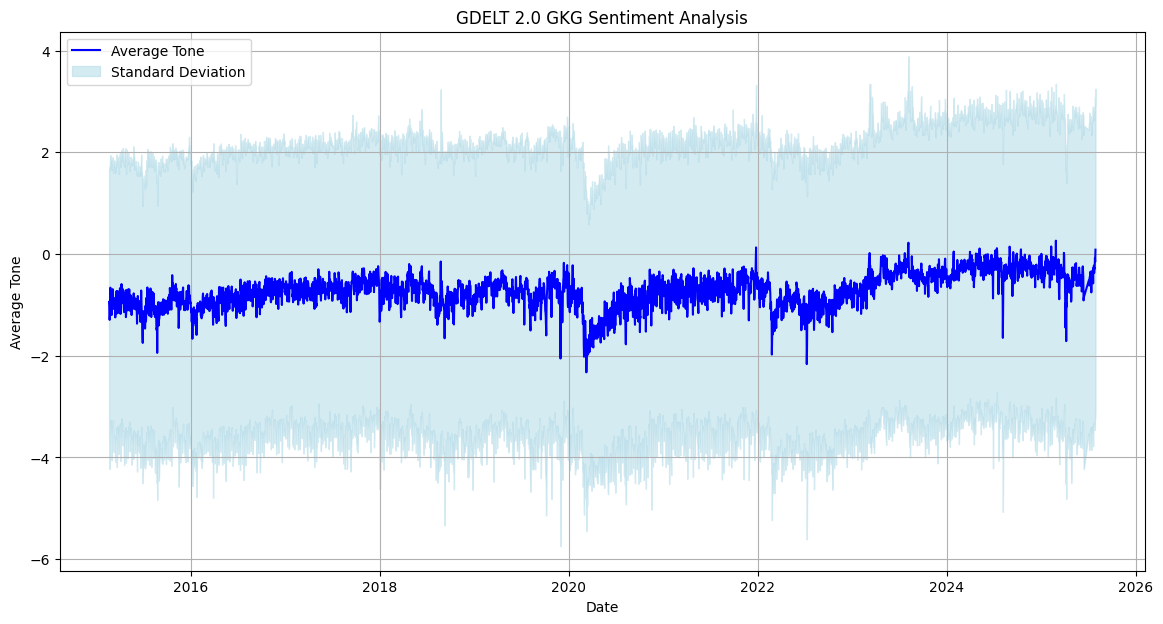

In [21]:
plot_gkg_sentiment(df_gkg, start=start, end=end)

In [22]:
# Save the processed DataFrame to a new CSV
df_gkg.to_csv("gkg_aggregate.csv", index=True)

Having obtained the aggregate sentiment data, let's try to visualise it against our regimes once more:

In [23]:
def plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=None, end=None, n=30):
    """
    Plots n-day rolling GDELT sentiment data with cumulative returns overlay, n-day MA, and regime shading.
    Handles both column-based and index-based datetime formats.
    """

    # --- Prepare sentiment data ---
    sentiment = df_gkg.copy()

    # Ensure datetime index
    if 'date' in sentiment.columns:
        sentiment['date'] = pd.to_datetime(sentiment['date'])
        sentiment.set_index('date', inplace=True)
    if not isinstance(sentiment.index, pd.DatetimeIndex):
        sentiment.index = pd.to_datetime(sentiment.index)

    sentiment['rolling_avg_tone'] = sentiment['avg_tone'].rolling(window=n, min_periods=1).mean()
    sentiment['rolling_std_tone'] = sentiment['avg_tone'].rolling(window=n, min_periods=1).std()
    sentiment[f'{n}DSMA'] = sentiment['avg_tone'].rolling(window=n, min_periods=1).mean()

    # --- Prepare price data ---
    price_df = df.copy()
    price_df = calculate_metrics(price_df)  # make sure this does not drop rows!
    price_df[f'{n}DMA'] = price_df['Close'].rolling(window=n, min_periods=1).mean()

    # --- Detect regimes ---
    n_components = 2
    df_regime, _ = detect_market_regimes(price_df, features=['Log Return', 'Volatility'], n_components=n_components)

    # --- Final slicing ---
    start = pd.to_datetime(start) if start else max(price_df.index.min(), sentiment.index.min())
    end = pd.to_datetime(end) if end else min(price_df.index.max(), sentiment.index.max())

    sentiment = sentiment.loc[start:end]
    price_df = price_df.loc[start:end]
    df_regime = df_regime.loc[start:end]

    # --- Regime color mapping ---
    regime_stats = []
    for i in range(n_components):
        mask = df_regime['Regime'] == i
        mean_ret = df_regime.loc[mask, 'Log Return'].mean()
        vol = df_regime.loc[mask, 'Log Return'].std()
        regime_stats.append({'regime': i, 'mean_ret': mean_ret, 'vol': vol})

    sorted_stats = sorted(regime_stats, key=lambda x: (x['mean_ret'], -x['vol']))
    regime_colors = {stat['regime']: color for stat, color in zip(sorted_stats, ['red', 'green'])}

    # --- Plotting ---
    fig, ax1 = plt.subplots(figsize=(14, 7))

    ax1.plot(sentiment.index, sentiment['rolling_avg_tone'], label=f'{n}-Day Rolling Avg Tone', color='blue')
    ax1.fill_between(
        sentiment.index,
        sentiment['rolling_avg_tone'] - sentiment['rolling_std_tone'],
        sentiment['rolling_avg_tone'] + sentiment['rolling_std_tone'],
        color='lightblue', alpha=0.5, label=f'{n}-Day Rolling Std'
    )
    ax1.plot(sentiment.index, sentiment[f'{n}DSMA'], label=f'{n}-Day SMA of Rolling Avg Tone', color='darkblue', linestyle='--')
    ax1.set_ylabel('Rolling Average Tone')
    ax1.legend(loc='upper left')
    ax1.grid(True)

    ax2 = ax1.twinx()
    ax2.plot(price_df.index, price_df['Close'], label='Price (Close)', color='orange')
    ax2.plot(price_df.index, price_df[f'{n}DMA'], label=f'{n}-Day MA', color='yellow', linestyle='--')
    ax2.set_ylabel('Price')
    ax2.legend(loc='upper right')

    # Regime shading
    current_regime = None
    start_date = None
    for date, regime in zip(df_regime.index, df_regime['Regime']):
        if regime != current_regime:
            if current_regime is not None:
                ax2.axvspan(start_date, date, color=regime_colors.get(current_regime, 'grey'), alpha=0.2)
            current_regime = regime
            start_date = date
    if start_date is not None:
        ax2.axvspan(start_date, df_regime.index[-1], color=regime_colors.get(current_regime, 'grey'), alpha=0.2)

    plt.title(f'{n}-Day Rolling GDELT Sentiment with Cumulative Returns, {n}-Day MA, and Regime Shading')
    plt.xlabel('Date')
    plt.show()


Regime 0: Mean Return = 0.00044, Volatility = 0.00657
Regime 1: Mean Return = -0.00002, Volatility = 0.01565


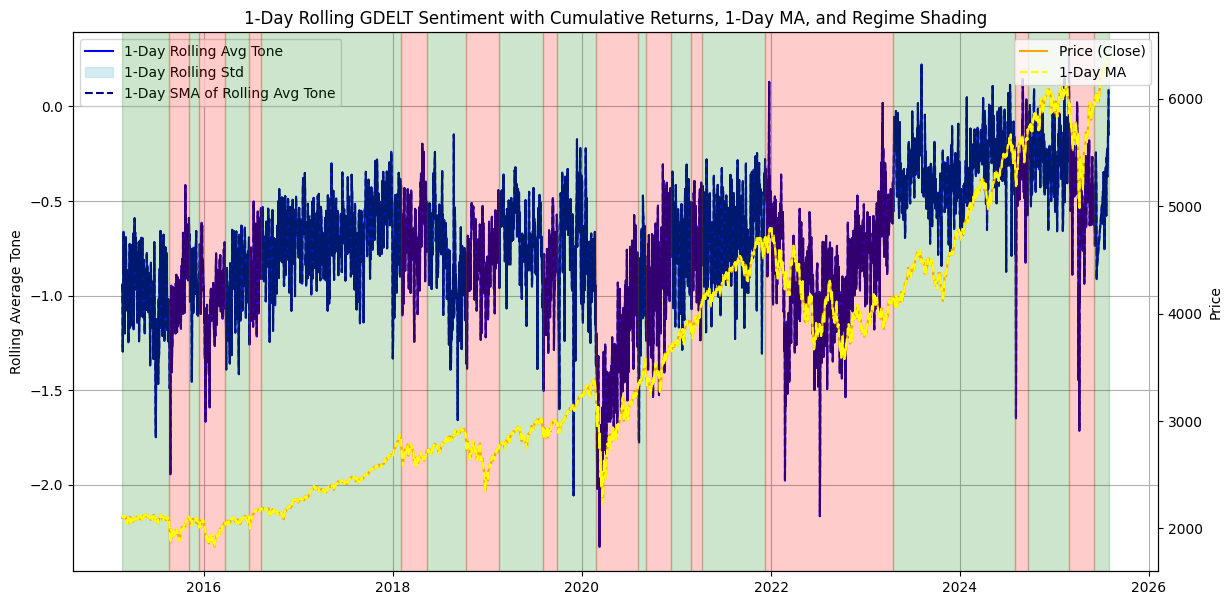

Regime 0: Mean Return = 0.00044, Volatility = 0.00657
Regime 1: Mean Return = -0.00002, Volatility = 0.01565


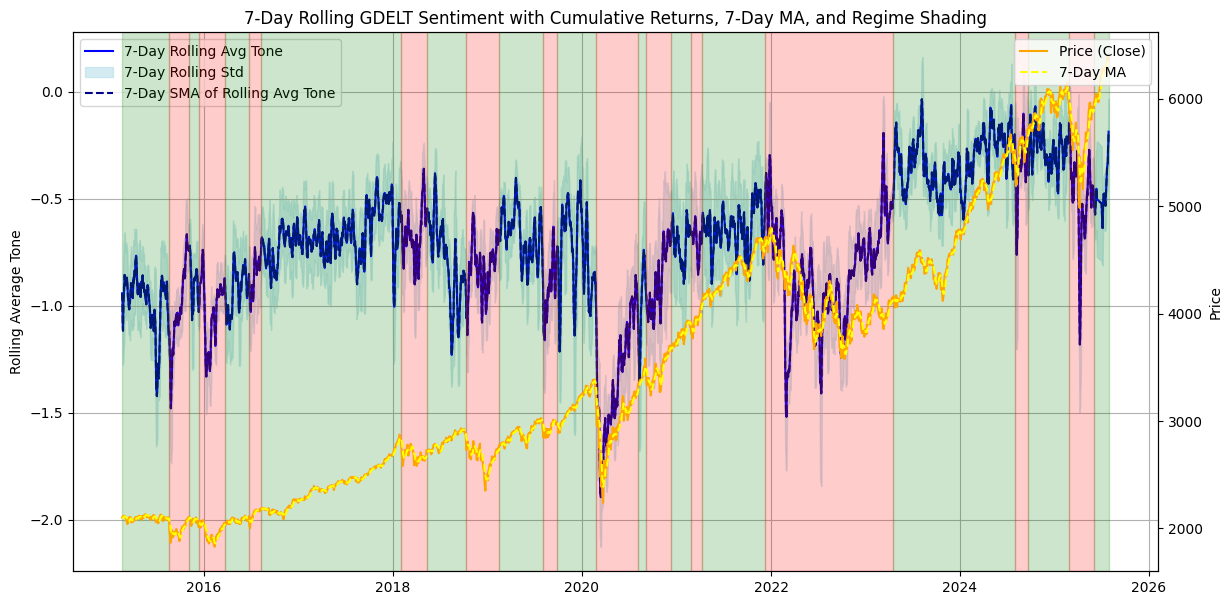

Regime 0: Mean Return = 0.00044, Volatility = 0.00657
Regime 1: Mean Return = -0.00002, Volatility = 0.01565


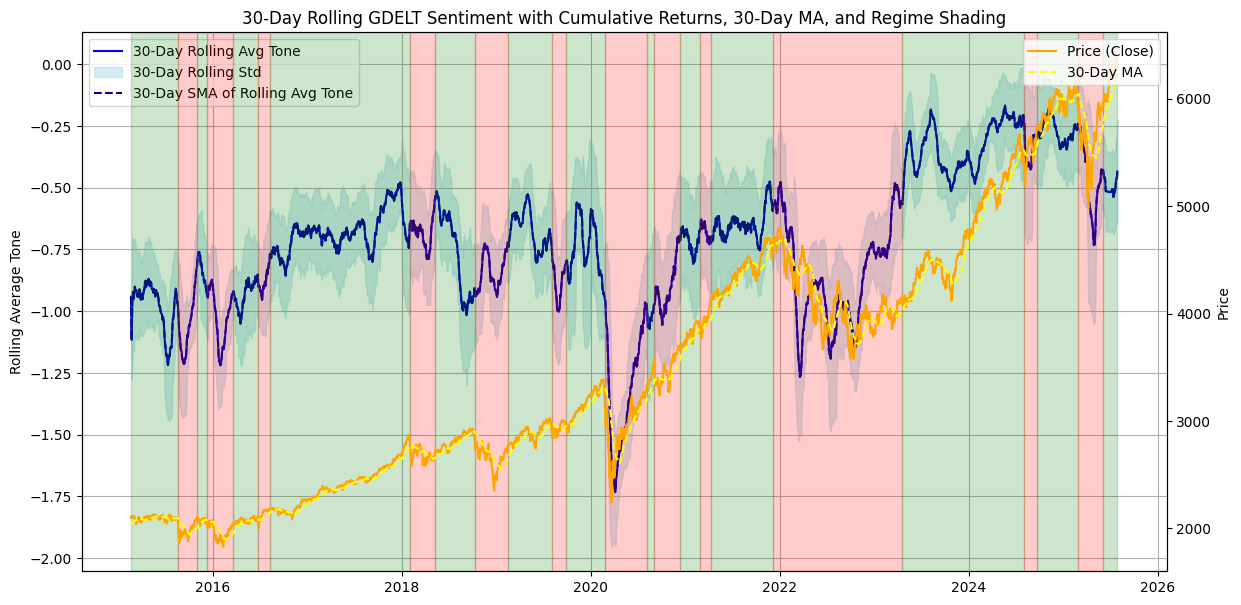

Regime 0: Mean Return = 0.00044, Volatility = 0.00657
Regime 1: Mean Return = -0.00002, Volatility = 0.01565


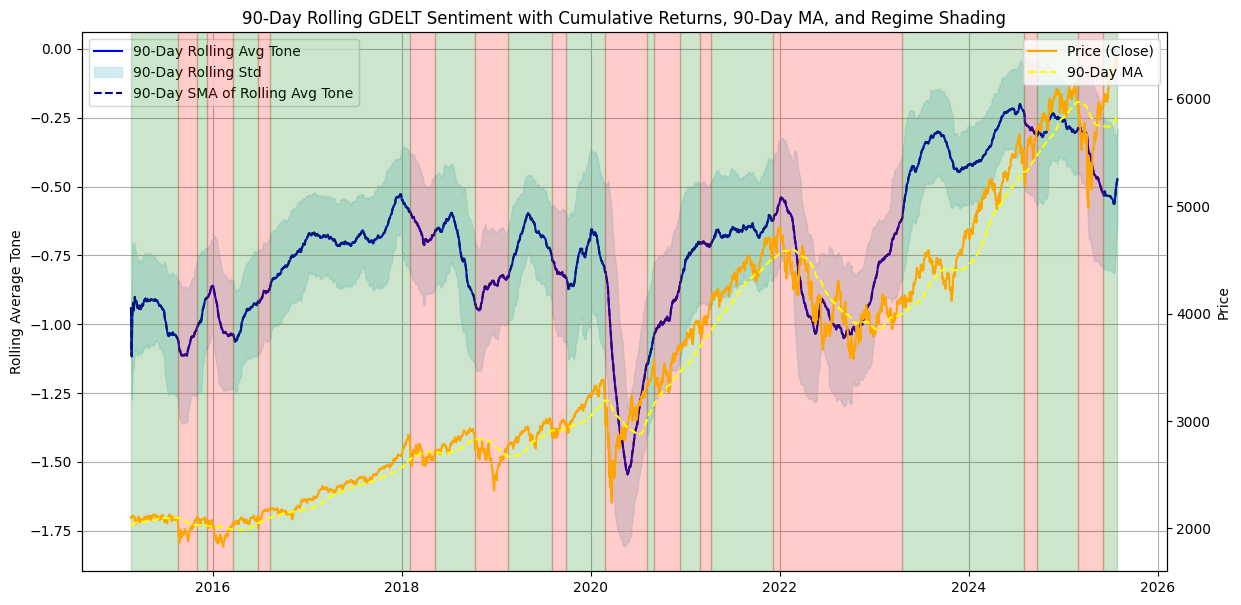

Regime 0: Mean Return = 0.00044, Volatility = 0.00657
Regime 1: Mean Return = -0.00002, Volatility = 0.01565


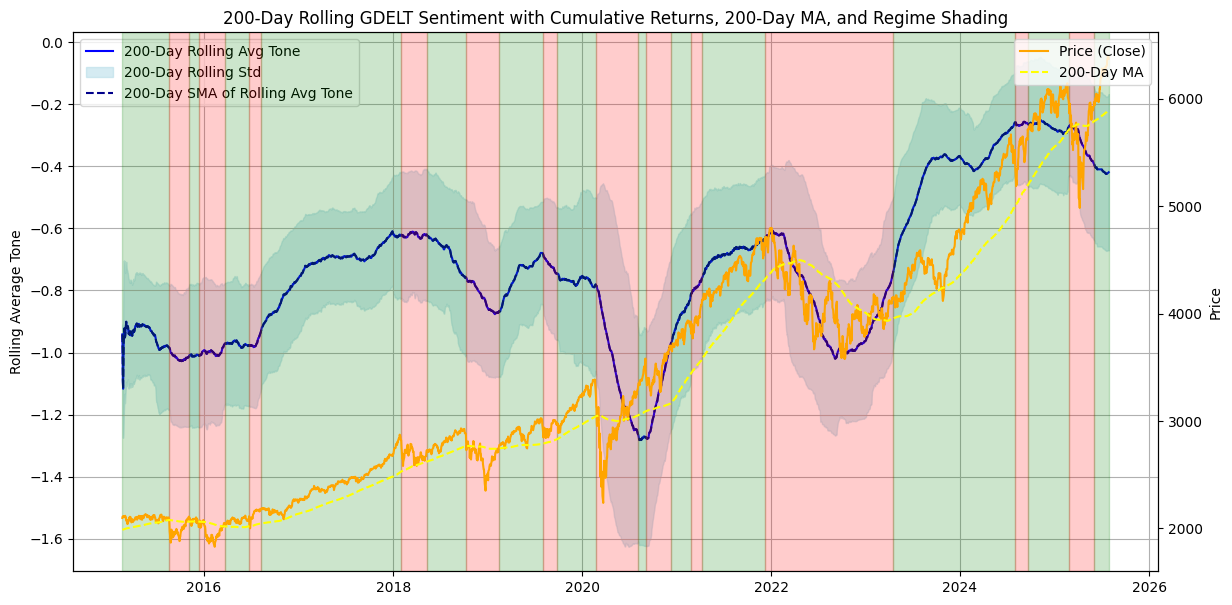

In [24]:
from datetime import datetime, timedelta

# Calculate 200 days before gkg_start
gkg_start_dt = datetime.strptime(gkg_start, "%Y-%m-%d")
gkg_start_minus_200 = (gkg_start_dt - timedelta(days=200)).strftime("%Y-%m-%d")

plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=1)
plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=7)
plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=30)
plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=90)
plot_gkg_sentiment_with_cumulative_returns(df_gkg, df, start=gkg_start, end=gkg_end, n=200)

From the graphs above, it can be seen that GDELT sentiment tends to follow regimes and price shifts (or perhaps the other way around), which is to be expected. Surprisingly, I believe that the daily GDELT sentiment graph offers the most insights. Before each large price fall, it seems that there tends to be a spike in sentiment across a small period. Anyhow, with the data at hand, let us try to create an algorithm that will let us profit moreso than a naive baseline.

The above is a rough idea of the algorithm. From the visualisation, we can see that there's a few conditions that we want to focus on, so let's define some clear conditions and guardrails for the algorithm:
- Consider **buy** only when price < 200DMA
- Consider **sell** only when price > 200DMA
- Calculate percentage confidence scores for buying or selling
- For **buy** confidence, consider if price trough is an inflexion point, 200MDA price deviation, sentiment change
- For **sell** confidence, consider if price peak is an inflexion point, 200MDA price deviation, sentiment change
- Consider modelling price direction prediction to help calculate confidence scores

In [25]:
import numpy as np
import pandas as pd

def causal_bopcd(series, window=21, threshold=2.0):
  """
  Causal Bayesian Online Point Change Detection (BOPCD) for peak/trough detection.
  Uses rolling z-score to detect significant changes (peaks/troughs) using only past data.

  Parameters:
  - series: pd.Series, time series data (e.g., smoothed price)
  - window: int, rolling window size for mean/std estimation
  - threshold: float, z-score threshold for change detection

  Returns:
  - peaks: pd.Series, detected peaks
  - troughs: pd.Series, detected troughs
  """
  rolling_mean = series.rolling(window=window, min_periods=1).mean()
  rolling_std = series.rolling(window=window, min_periods=1).std(ddof=0)
  zscore = (series - rolling_mean) / (rolling_std + 1e-8)

  peaks = series[(zscore > threshold)]
  troughs = series[(zscore < -threshold)]

  return peaks, troughs

# Example usage:
# peaks_bopcd, troughs_bopcd = causal_bopcd(smoothed, window=21, threshold=2.0)

In [26]:
# Use the raw closing prices as the smoothed price series for peak/trough detection
price_raw_values = df['Close']
peaks_bopcd, troughs_bopcd = causal_bopcd(price_raw_values, window=21, threshold=2.0)

In [27]:
import matplotlib.pyplot as plt

# Plot peaks, troughs, and 200DMA
def plot_turning_points(df, raw_values, peaks, troughs, start=None, end=None):
    """
    Plots the raw price series with detected peaks and troughs,
    and overlays the 200-day moving average.

    Parameters:
    - df: DataFrame with DateTime index and a '200DMA' column
    - raw_values: pd.Series, raw price series
    - peaks: pd.Series, detected peaks
    - troughs: pd.Series, detected troughs
    - start: str or datetime (optional), start date for slicing
    - end: str or datetime (optional), end date for slicing
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)
    df['200DMA'] = df['Close'].rolling(window=200, min_periods=50).mean()

    if start or end:
        df = df.loc[start:end]
        raw_values = raw_values.loc[start:end]
        peaks = peaks.loc[start:end]
        troughs = troughs.loc[start:end]

    fig, ax1 = plt.subplots(figsize=(28, 7))

    # Raw price
    ax1.plot(df.index, raw_values, label='Raw Price', color='blue')
    ax1.scatter(peaks.index, peaks.values, color='red', label='Peaks', marker='^')
    ax1.scatter(troughs.index, troughs.values, color='green', label='Troughs', marker='v')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price')
    ax1.grid(True)

    # 200-day moving average (overlayed on same axis)
    if '200DMA' in df.columns:
        ax1.plot(df.index, df['200DMA'], label='200-Day MA', color='black', linestyle='--')

    # Final formatting
    ax1.set_title('Detected Peaks and Troughs in Raw Price Series')
    ax1.legend()
    plt.show()


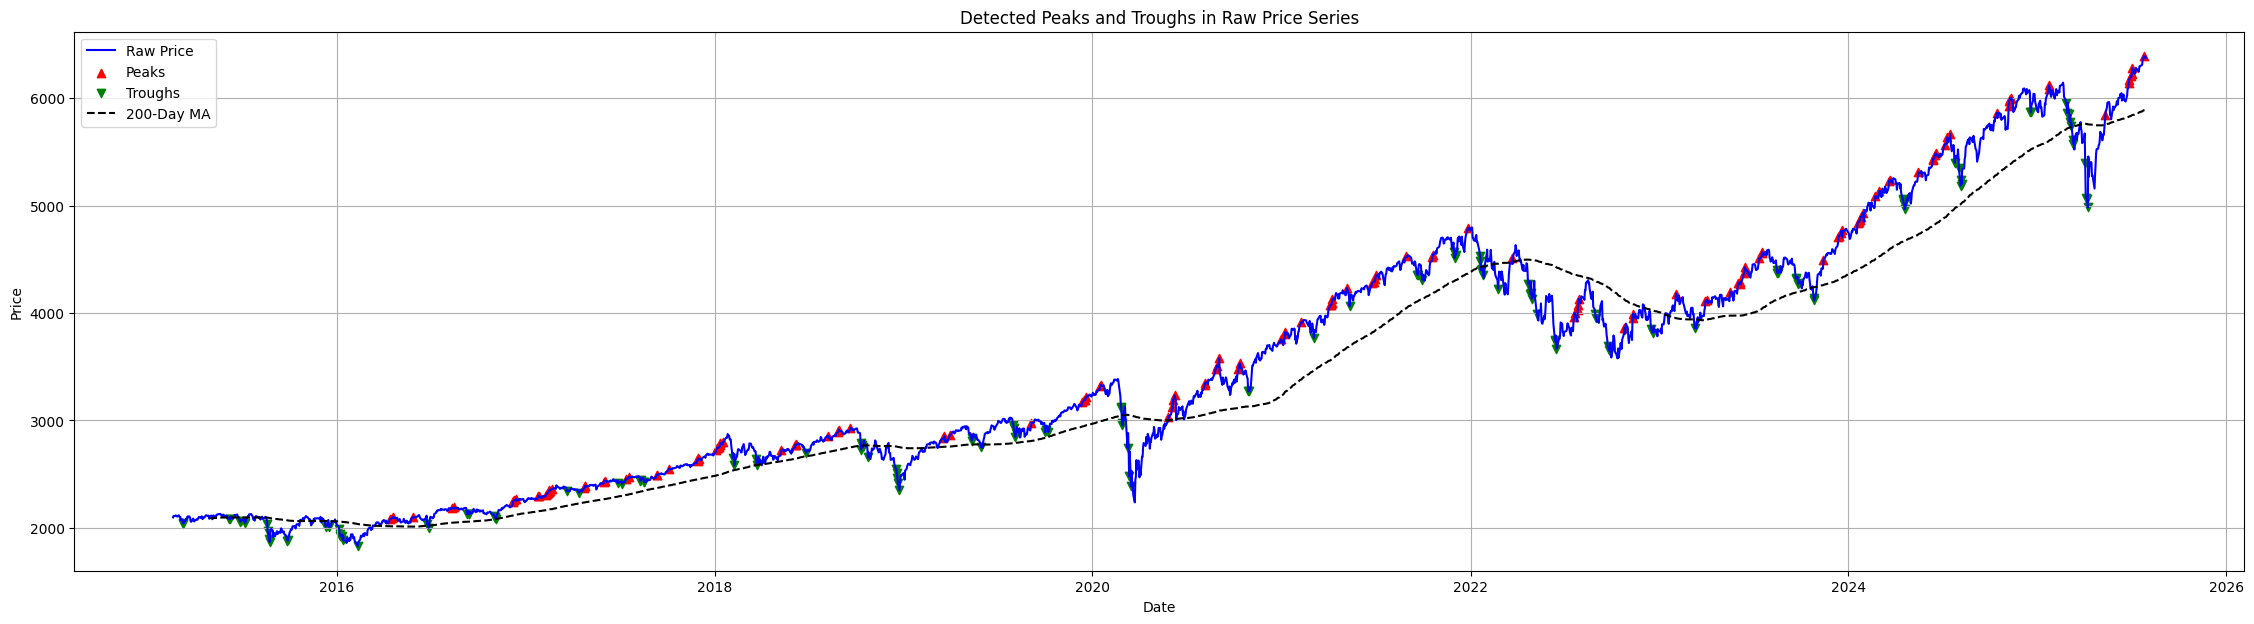

In [28]:
# Slice smoothed, peaks, and troughs to match the filtered df
df_filtered = df.loc[gkg_start:gkg_end]
raw_filtered = price_raw_values.loc[gkg_start:gkg_end]
peaks_filtered = peaks_bopcd.loc[gkg_start:gkg_end]
troughs_filtered = troughs_bopcd.loc[gkg_start:gkg_end]

plot_turning_points(df_filtered, price_raw_values, peaks_filtered, troughs_filtered, start=gkg_start, end=gkg_end)

In [29]:
def s_transform(x, k=5):
    return 2 / (1 + np.exp(-k * x)) - 1

def calculate_sentiment_confidence(row):
    if pd.isna(row['Sentiment']) or pd.isna(row['Sentiment_200DSMA']):
        return pd.Series({'Buy Confidence': np.nan, 'Sell Confidence': np.nan})
    deviation = row['Sentiment'] - row['Sentiment_200DSMA']
    buy_conf = s_transform(-deviation, k=4)
    sell_conf = s_transform(deviation, k=4)
    return pd.Series({'Buy Confidence': buy_conf, 'Sell Confidence': sell_conf})

def plot_turning_points_with_sentiment(df, df_gkg, peaks, troughs, start=None, end=None, calculate_sentiment_confidence=calculate_sentiment_confidence):
    # --- Prepare price data ---
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Ensure df_gkg index is datetime
    df_gkg = df_gkg.copy()
    if not isinstance(df_gkg.index, pd.DatetimeIndex):
        df_gkg.index = pd.to_datetime(df_gkg.index)

    # Merge and compute features
    df = df.merge(df_gkg, left_index=True, right_index=True, how='left')
    df['Sentiment'] = df['avg_tone'].rolling(window=90, min_periods=30).mean()
    df['Sentiment_200DSMA'] = df['Sentiment'].rolling(window=200, min_periods=50).mean()
    df['200DMA'] = df['Close'].rolling(window=200, min_periods=50).mean()
    df['200DMA Percentage Price Deviation'] = (df['Close'] - df['200DMA']) / df['200DMA']

    # Apply sentiment-based confidence
    sentiment_confidence = df.apply(calculate_sentiment_confidence, axis=1)
    df = pd.concat([df, sentiment_confidence], axis=1)

    # Date filter at the end
    if start or end:
        df = df.loc[start:end]
        peaks = peaks.loc[start:end]
        troughs = troughs.loc[start:end]

    # Align confidence to peaks/troughs
    peaks_conf = df['Sell Confidence'].reindex(peaks.index).fillna(0)
    troughs_conf = df['Buy Confidence'].reindex(troughs.index).fillna(0)

    # --- Plotting ---
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(28, 10), sharex=True, height_ratios=[2, 1])

    # Identify continuous spans
    df['Below 200DMA'] = df['200DMA Percentage Price Deviation'] < 0
    # Step 1: Identify contiguous blocks using run-length encoding logic
    df['Block'] = (df['Below 200DMA'] != df['Below 200DMA'].shift()).cumsum()

    # Step 2: Group by blocks to find start and end indices for each segment
    spans = df.groupby('Block').agg(
        Start=('Below 200DMA', lambda x: x.index[0]),
        End=('Below 200DMA', lambda x: x.index[-1]),
        IsBelow=('Below 200DMA', 'first')
    )

    # Price and turning points (ax1)
    ax1.plot(df.index, df['Close'], label='Raw Price', color='blue')
    ax1.plot(df.index, df['200DMA'], label='200DMA', color='black', linestyle='--')

    ax1.scatter(peaks.index, peaks.values,
                s=np.square(peaks_conf) * 500 + 10,
                color='green', label='Peaks', marker='^', edgecolors='black', zorder=5)

    ax1.scatter(troughs.index, troughs.values,
                s=np.square(troughs_conf) * 500 + 10,
                color='red', label='Troughs', marker='v', edgecolors='black', zorder=5)

    ax1.set_title('Turning Points with Sentiment-Based Confidence')
    ax1.set_ylabel('Price')
    ax1.legend()
    ax1.grid(True)

    # Confidence subplot (ax2)

    # Step 3: Apply background shading on ax1
    for _, row in spans.iterrows():
        color = 'red' if row['IsBelow'] else 'green'
        ax2.axvspan(row['Start'], row['End'], color=color, alpha=0.06, zorder=0)

    ax2.plot(df.index, df['Buy Confidence'], color='red', label='Buy Confidence')
    ax2.plot(df.index, df['Sell Confidence'], color='green', label='Sell Confidence')
    ax2.axhline(0, color='gray', linestyle='--')
    ax2.set_ylabel('Confidence')
    ax2.set_xlabel('Date')
    ax2.set_ylim(0, 1)
    ax2.legend()
    ax2.grid(True)
    ax2.set_title('Sentiment-Based Confidence Scores Over Time')

    plt.tight_layout()
    plt.show()

    return df


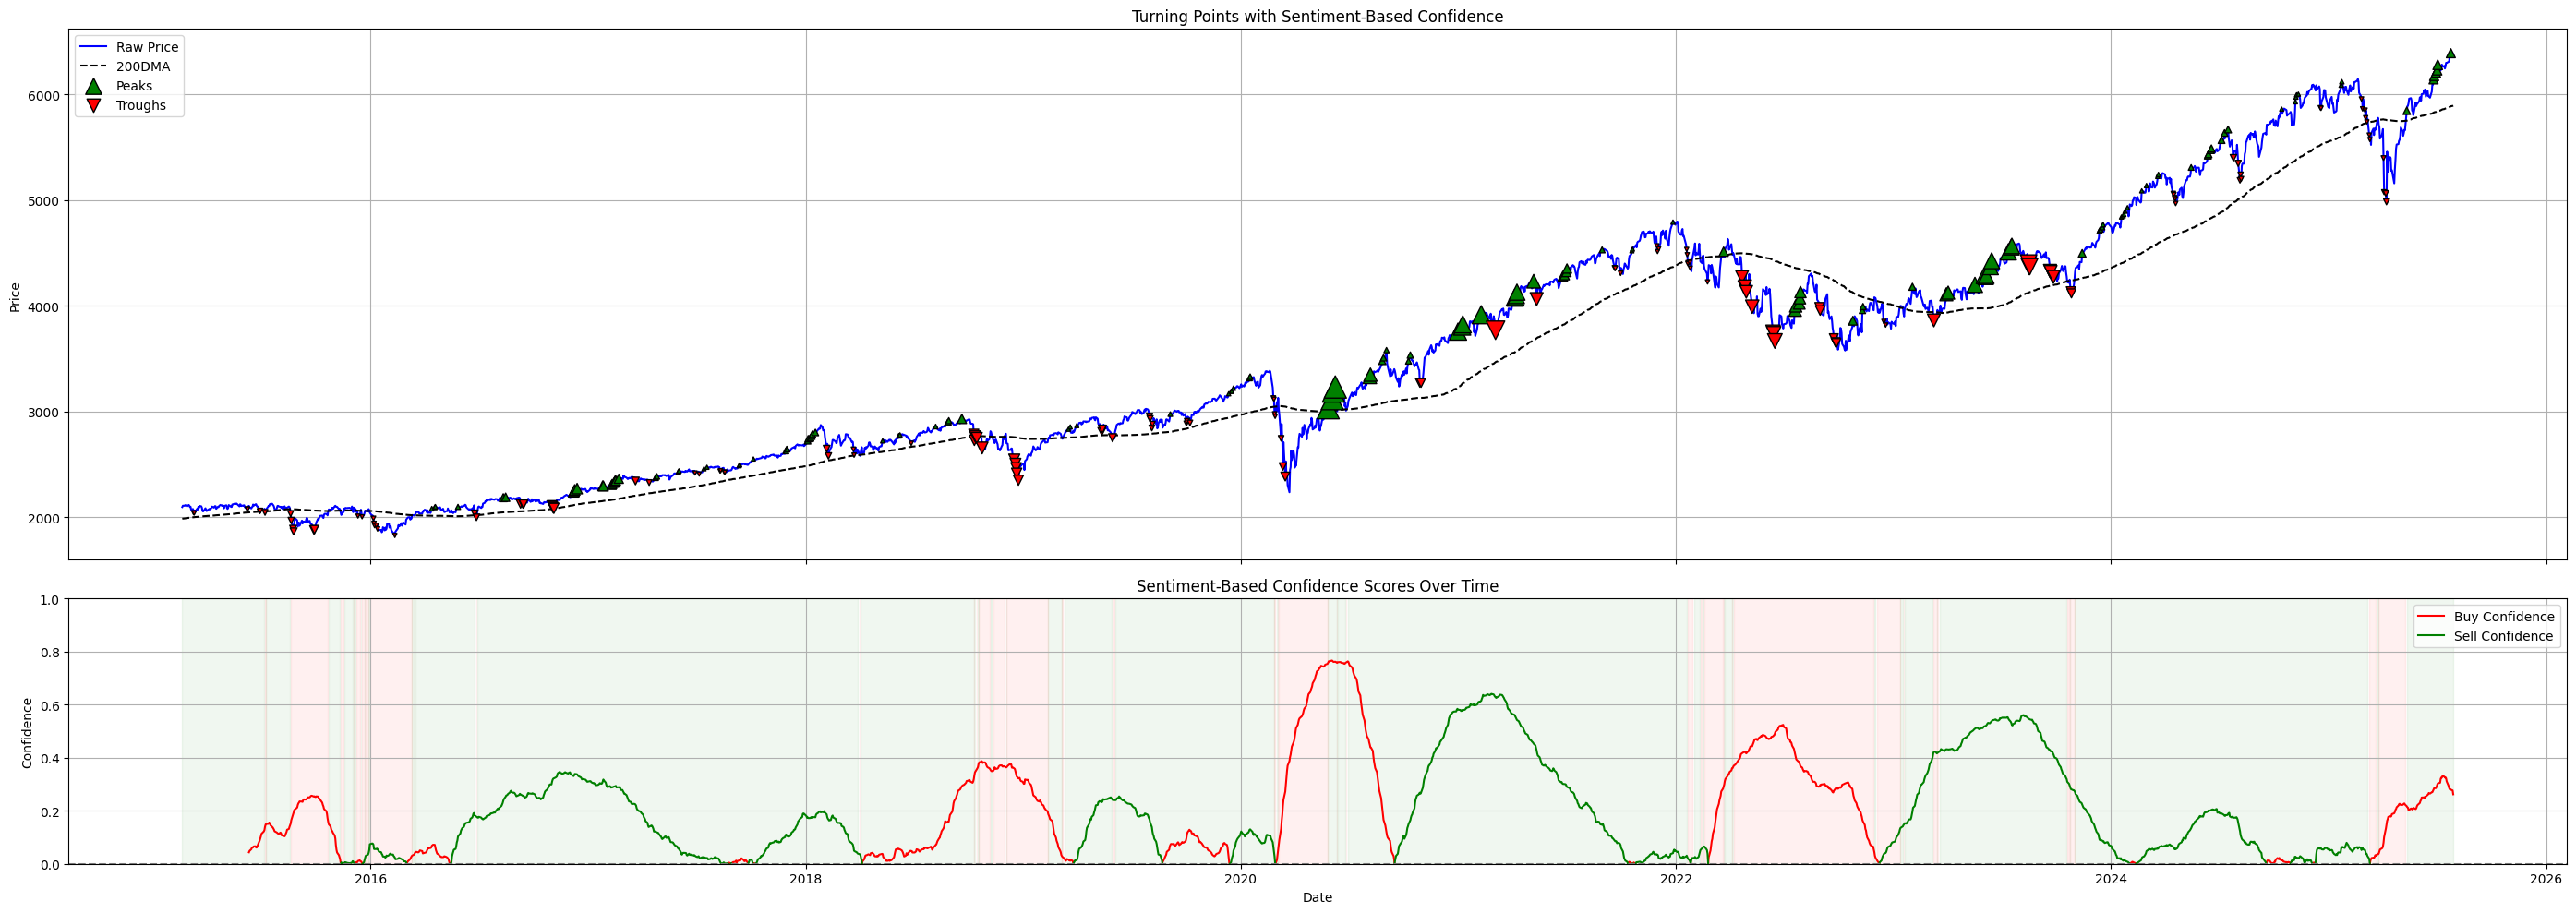

In [30]:
df_with_sentiment = plot_turning_points_with_sentiment(df, df_gkg, peaks_filtered, troughs_filtered, start=gkg_start, end=gkg_end, calculate_sentiment_confidence=calculate_sentiment_confidence)

In [31]:
def calculate_sentiment_confidence2(row, weight_sentiment=1.0, weight_price=1.0):
    if pd.isna(row['Sentiment']) or pd.isna(row['Sentiment_200DSMA']):
        return pd.Series({'Buy Confidence': np.nan, 'Sell Confidence': np.nan})
    deviation = row['Sentiment'] - row['Sentiment_200DSMA']
    price_deviation = row['200DMA Percentage Price Deviation']
    buy_conf = weight_sentiment * s_transform(-deviation, k=4) + weight_price * s_transform(-price_deviation, k=4)
    sell_conf = weight_sentiment * s_transform(deviation, k=4) + weight_price * s_transform(price_deviation, k=4)
    return pd.Series({'Buy Confidence': buy_conf, 'Sell Confidence': sell_conf})

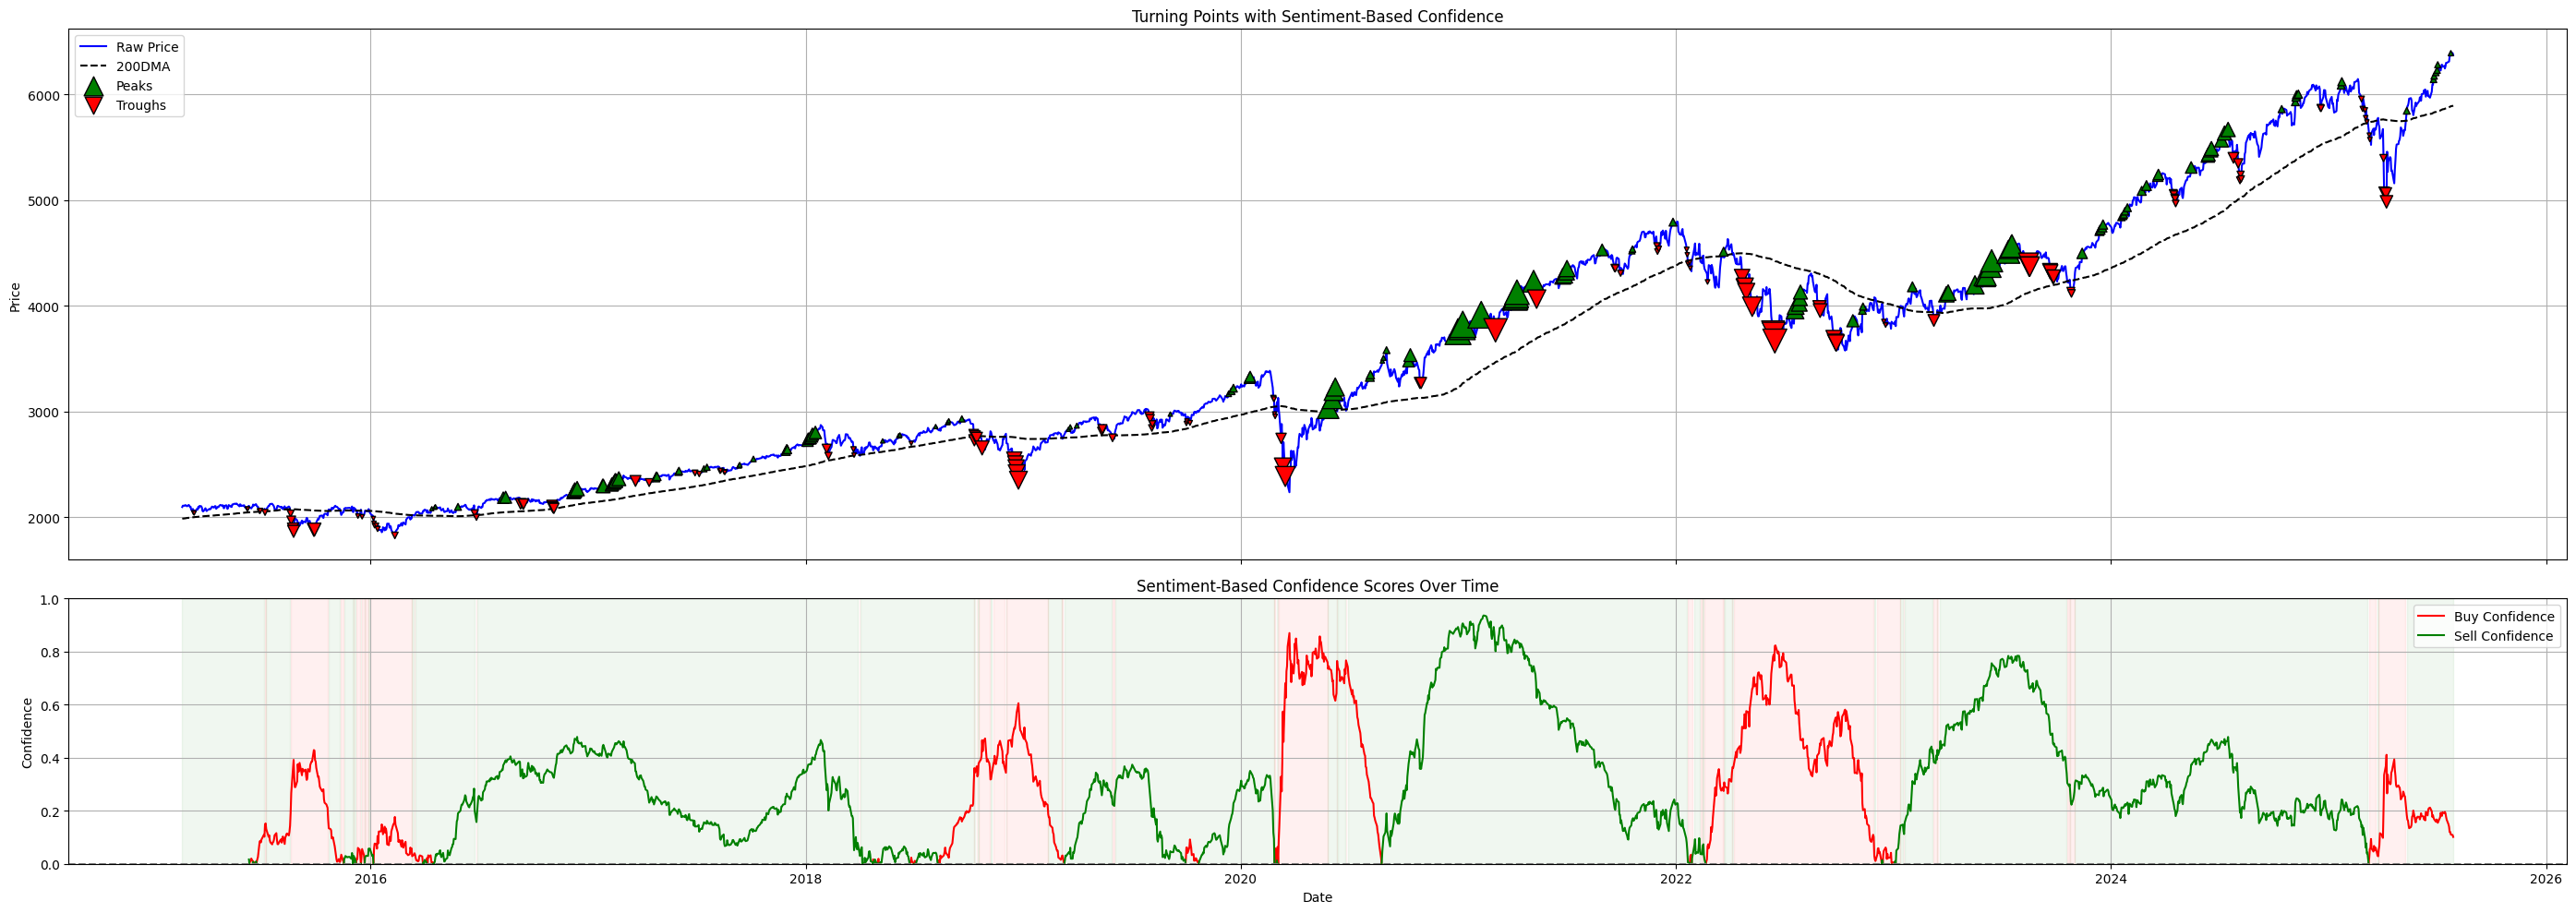

In [32]:
df_with_sentiment = plot_turning_points_with_sentiment(df, df_gkg, peaks_filtered, troughs_filtered, start=gkg_start, end=gkg_end, calculate_sentiment_confidence=calculate_sentiment_confidence2)

Insights & Possible Strategy:
- Buy troughs when buy confidence is plateauing / high
- Buy troughs when sell confidence is increasing / high
- Sell peaks when sell confidence is plateauing / high
- Sell peaks when buy confidence is increasing / high

Let's test the strategy where above. We can test it against two different approaches: (strict) 1 where we only buy if price < 200DMA and sell if price > 200DMA, (relaxed) 2 where we buy and sell according to the insights at each estimated peak and trough.

In [33]:
def simulate_strategy_strict(df, initial_cash=100_000, 
                             buy_threshold=0.5, sell_threshold=0.5, 
                             plateau_buy_threshold=0.1, plateau_sell_threshold=0.1, 
                             buy_gradient_threshold=0.1, sell_gradient_threshold=0.1):
    """
    Simulate trading strategy based on confidence signals and detected turning points.

    Parameters:
    - df: DataFrame with columns ['Close', 'Buy Confidence', 'Sell Confidence', 'is_peak', 'is_trough']
    - initial_cash: Starting capital (default: 100,000)
    - buy_threshold: Minimum confidence level to consider plateau/increase significant
    - sell_threshold: Same as above, for sell signals

    Returns:
    - final_portfolio_value: Final value of cash + holdings
    - df_trades: DataFrame of all executed trades
    """
    cash = initial_cash
    shares = 0 
    trade_log = []
    skip_log = []

    df = df.copy().dropna(subset=["Close", "Buy Confidence", "Sell Confidence"])
    df["Rolling Buy Confidence 7"] = df["Buy Confidence"].rolling(window=7, min_periods=1).mean()
    df["Rolling Buy Confidence 30"] = df["Buy Confidence"].rolling(window=30, min_periods=1).mean()
    df["Rolling Sell Confidence 7"] = df["Sell Confidence"].rolling(window=7, min_periods=1).mean()
    df["Rolling Sell Confidence 30"] = df["Sell Confidence"].rolling(window=30, min_periods=1).mean()
    df["Buy Gradient"] = df["Rolling Buy Confidence 7"].diff().fillna(0)
    df["Sell Gradient"] = df["Rolling Sell Confidence 7"].diff().fillna(0)
    df["Buy Gradient 7"] = df["Buy Gradient"].rolling(window=7, min_periods=1).mean()
    df["Buy Gradient 30"] = df["Buy Gradient"].rolling(window=30, min_periods=1).mean()
    df["Sell Gradient 7"] = df["Sell Gradient"].rolling(window=7, min_periods=1).mean()
    df["Sell Gradient 30"] = df["Sell Gradient"].rolling(window=30, min_periods=1).mean()

    for i in range(1, len(df)):
        row = df.iloc[i]
        prev = df.iloc[i - 1]
        price = row["Close"]

        # Consider implementing transaction costs

        # Buy logic
        if row["is_trough"]:
            # Check plateau or increasing buy confidence (during positive buy confidence)
            plateau_buy = row["Buy Gradient 7"] <= row["Buy Gradient 30"] and row["Buy Gradient 7"] <= plateau_buy_threshold and row["Buy Confidence"] >= buy_threshold
            # Check increasing buy confidence (during positive sell confidence)
            increasing_buy = row["Sell Gradient 7"] >= buy_gradient_threshold
            if plateau_buy or increasing_buy: # can buy partial shares
                buy_reason = ""
                if plateau_buy:
                    buy_reason = "Plateau conditions met"
                elif increasing_buy:
                    buy_reason = "Increasing buy confidence"
                shares_to_buy = int(cash // price)
                if shares_to_buy > 0:
                    cash -= shares_to_buy * price
                    shares += shares_to_buy
                    trade_log.append((row.name, "BUY", price, shares_to_buy, cash,row["Buy Confidence"], row["Buy Gradient 7"], buy_reason))
            else:
                skip_reason = ""
                if row["Buy Confidence"] < buy_threshold:
                    skip_reason = "Insufficient buy confidence"
                elif row["Rolling Buy Confidence 7"] > row["Rolling Buy Confidence 30"]:
                    skip_reason = "Plateau conditions not met"
                elif row["Rolling Buy Confidence 7"] < plateau_buy_threshold:
                    skip_reason = "Insufficient plateau confidence"
                skip_log.append((row.name, "BUY", price, shares, cash, row["Buy Confidence"], row["Buy Gradient 7"], skip_reason))

        # Sell logic
        elif row["is_peak"]:
            # Check plateau or increasing sell confidence (during positive sell confidence)
            plateau_sell = row["Sell Gradient 7"] <= row["Sell Gradient 30"] and row["Sell Gradient 7"] <= plateau_sell_threshold and row["Sell Confidence"] >= sell_threshold
            # Check increasing sell confidence (during positive buy confidence)
            increasing_sell = row["Buy Gradient 7"] >= sell_gradient_threshold
            if (plateau_sell or increasing_sell) and shares > 0:
                sell_reason = ""
                if plateau_sell:
                    sell_reason = "Plateau conditions met"
                elif increasing_sell:
                    sell_reason = "Increasing sell confidence"
                cash += shares * price
                trade_log.append((row.name, "SELL", price, shares, cash, row["Sell Confidence"], row["Sell Gradient 7"], sell_reason))
                shares = 0
            else:
                skip_reason = ""
                if row["Sell Confidence"] < sell_threshold:
                    skip_reason = "Insufficient sell confidence"
                elif row["Rolling Sell Confidence 7"] > row["Rolling Sell Confidence 30"]:
                    skip_reason = "Plateau conditions not met"
                elif row["Rolling Sell Confidence 7"] < plateau_sell_threshold:
                    skip_reason = "Insufficient plateau confidence"
                elif shares == 0:
                    skip_reason = "No shares to sell"
                skip_log.append((row.name, "SELL", price, shares, cash, row["Sell Confidence"], row["Sell Gradient 7"], skip_reason))

    # Final portfolio value
    final_price = df.iloc[-1]["Close"]
    portfolio_value = cash + shares * final_price

    df_trades = pd.DataFrame(trade_log, columns=["Date", "Action", "Price", "Shares", "Cash", "Buy / Sell Confidence", "Buy / Sell Gradient", "Reason"])
    df_skips = pd.DataFrame(skip_log, columns=["Date", "Action", "Price", "Shares", "Cash", "Buy / Sell Confidence", "Buy / Sell Gradient", "Reason"])
    return portfolio_value, df_trades, df_skips


In [34]:
# Add is_peak and is_trough columns to df_with_sentiment
df_with_sentiment = df_with_sentiment.copy()
df_with_sentiment['is_peak'] = df_with_sentiment.index.isin(peaks_filtered.index)
df_with_sentiment['is_trough'] = df_with_sentiment.index.isin(troughs_filtered.index)

from IPython.display import display, HTML

def display_scrollable(df, max_height='300px'):
    html = df.to_html(max_rows=1000)
    styled_html = f"""
    <div style="overflow-y: scroll; max-height: {max_height}; border: 1px solid #ccc">
        {html}
    </div>
    """
    display(HTML(styled_html))

# Usage
portfolio_value, trade_log, skip_log = simulate_strategy_strict(df_with_sentiment, buy_threshold=0.1, sell_threshold=0.2)
print(f"Final portfolio value: ${portfolio_value:,.2f}")
display(trade_log)
display_scrollable(skip_log)

Final portfolio value: $185,323.90


,Date,Action,Price,Shares,Cash,Buy / Sell Confidence,Buy / Sell Gradient,Reason
0,2015-09-28,BUY,1881.770020,53,266.188965,0.428735,0.005489,Plateau conditions met
1,2016-08-11,SELL,2185.790039,53,116113.061035,0.371704,0.003529,Plateau conditions met
2,2018-10-10,BUY,2785.679932,41,1900.183838,0.304304,0.005582,Plateau conditions met
3,2020-01-16,SELL,3316.810059,41,137889.396240,0.341970,0.003184,Plateau conditions met
4,2022-06-13,BUY,3749.629883,36,2902.720459,0.780740,0.001515,Plateau conditions met
5,2023-06-02,SELL,4282.370117,36,157068.044678,0.671091,0.002724,Plateau conditions met
6,2025-04-03,BUY,5396.520020,29,568.964111,0.205543,0.008354,Plateau conditions met


,Date,Action,Price,Shares,Cash,Buy / Sell Confidence,Buy / Sell Gradient,Reason
0,2015-06-29,BUY,2057.639893,0,100000.000000,0.083843,0.001962,Insufficient buy confidence
1,2015-06-30,BUY,2063.110107,0,100000.000000,0.086657,0.003511,Insufficient buy confidence
2,2015-07-08,BUY,2046.680054,0,100000.000000,0.148955,0.013620,Plateau conditions not met
3,2015-08-20,BUY,2035.729980,0,100000.000000,0.192369,0.005294,Plateau conditions not met
4,2015-08-21,BUY,1970.890015,0,100000.000000,0.266871,0.008335,Plateau conditions not met
5,2015-08-24,BUY,1893.209961,0,100000.000000,0.361466,0.013006,Plateau conditions not met
6,2015-08-25,BUY,1867.609985,0,100000.000000,0.391770,0.017974,Plateau conditions not met
7,2015-12-11,BUY,2012.369995,53,266.188965,0.059932,0.005209,Insufficient buy confidence
8,2015-12-18,BUY,2005.550049,53,266.188965,0.055786,0.006361,Insufficient buy confidence
9,2016-01-06,BUY,1990.260010,53,266.188965,-0.004718,-0.006847,Insufficient buy confidence


Improvements:
- Adjust sentiment moving average window/confidence by speed of change (e.g. Covid period had rapid changes in pricing and sentiment)
- Adjust threshold based on recent data, historical highs and historical lows
- Include guardrails

In the next section, we will try to remodel momentum, since the plateau conditions are very arbitrarily defined and is currently limiting our profits.

In [35]:
import pandas as pd
from scipy.stats import ttest_1samp, norm

def rolling_pval(series, window=30):
    result = []
    for i in range(len(series)):
        if i < window:
            result.append(None)
        else:
            sample = series.iloc[i-window:i]
            tstat, pval = ttest_1samp(sample, series.iloc[i])
            result.append(pval)
    return pd.Series(result, index=series.index)

def simulate_strategy_strict(df, initial_cash=100_000, 
                             buy_threshold=0.5, sell_threshold=0.5, 
                             plateau_buy_threshold=0.1, plateau_sell_threshold=0.1, 
                             buy_gradient_threshold=0.1, sell_gradient_threshold=0.1,
                             zscore_threshold=1.5, pval_threshold=0.05):
    cash = initial_cash
    shares = 0 
    trade_log = []
    skip_log = []

    df = df.copy().dropna(subset=["Close", "Buy Confidence", "Sell Confidence"])
    
    # Rolling stats
    df["Rolling Buy Confidence 7"] = df["Buy Confidence"].rolling(window=7, min_periods=1).mean()
    df["Rolling Buy Confidence 30"] = df["Buy Confidence"].rolling(window=30, min_periods=1).mean()
    df["Rolling Sell Confidence 7"] = df["Sell Confidence"].rolling(window=7, min_periods=1).mean()
    df["Rolling Sell Confidence 30"] = df["Sell Confidence"].rolling(window=30, min_periods=1).mean()

    # Gradients
    df["Buy Gradient"] = df["Rolling Buy Confidence 7"].diff().fillna(0)
    df["Sell Gradient"] = df["Rolling Sell Confidence 7"].diff().fillna(0)
    df["Buy Gradient 7"] = df["Buy Gradient"].rolling(window=7, min_periods=1).mean()
    df["Buy Gradient 30"] = df["Buy Gradient"].rolling(window=30, min_periods=1).mean()
    df["Sell Gradient 7"] = df["Sell Gradient"].rolling(window=7, min_periods=1).mean()
    df["Sell Gradient 30"] = df["Sell Gradient"].rolling(window=30, min_periods=1).mean()

    # Momentum
    df["Buy Momentum"] = df["Buy Confidence"].pct_change(periods=7)
    df["Sell Momentum"] = df["Sell Confidence"].pct_change(periods=7)

    # Z-scores and probabilities
    df["Buy Z"] = (df["Buy Confidence"] - df["Buy Confidence"].rolling(30).mean()) / df["Buy Confidence"].rolling(30).std()
    df["Sell Z"] = (df["Sell Confidence"] - df["Sell Confidence"].rolling(30).mean()) / df["Sell Confidence"].rolling(30).std()
    df["Buy Prob"] = norm.cdf(df["Buy Z"])
    df["Sell Prob"] = norm.cdf(df["Sell Z"])

    # p-values
    df["Buy pval"] = rolling_pval(df["Buy Confidence"])
    df["Sell pval"] = rolling_pval(df["Sell Confidence"])

    for i in range(1, len(df)):
        row = df.iloc[i]
        price = row["Close"]

        zscore_buy_extreme = row["Buy Z"] > zscore_threshold
        pval_buy_significant = row["Buy pval"] < pval_threshold
        zscore_sell_extreme = row["Sell Z"] > zscore_threshold
        pval_sell_significant = row["Sell pval"] < pval_threshold

        # Buy logic
        if row["is_trough"]:
            plateau_buy = row["Buy Gradient 7"] <= row["Buy Gradient 30"] and row["Buy Gradient 7"] <= plateau_buy_threshold and row["Buy Confidence"] >= buy_threshold
            increasing_buy = row["Sell Gradient 7"] >= buy_gradient_threshold

            if plateau_buy or increasing_buy or zscore_buy_extreme or pval_buy_significant:
                buy_reason = " | ".join([
                    r for cond, r in [
                        (plateau_buy, "Plateau conditions met"),
                        (increasing_buy, "Increasing buy confidence"),
                        (zscore_buy_extreme, "Z-score extreme"),
                        (pval_buy_significant, "p-value significant")
                    ] if cond
                ])
                shares_to_buy = int(cash // price)
                if shares_to_buy > 0:
                    cash -= shares_to_buy * price
                    shares += shares_to_buy
                    trade_log.append((row.name, "BUY", price, shares_to_buy, cash,
                                      row["Buy Confidence"], row["Buy Gradient 7"], buy_reason))
            else:
                skip_log.append((row.name, "BUY", price, shares, cash, row["Buy Confidence"],
                                 row["Buy Gradient 7"], "No buy condition met"))

        # Sell logic
        elif row["is_peak"]:
            plateau_sell = row["Sell Gradient 7"] <= row["Sell Gradient 30"] and row["Sell Gradient 7"] <= plateau_sell_threshold and row["Sell Confidence"] >= sell_threshold
            increasing_sell = row["Buy Gradient 7"] >= sell_gradient_threshold

            if (plateau_sell or increasing_sell or zscore_sell_extreme or pval_sell_significant) and shares > 0:
                sell_reason = " | ".join([
                    r for cond, r in [
                        (plateau_sell, "Plateau conditions met"),
                        (increasing_sell, "Increasing sell confidence"),
                        (zscore_sell_extreme, "Z-score extreme"),
                        (pval_sell_significant, "p-value significant")
                    ] if cond
                ])
                cash += shares * price
                trade_log.append((row.name, "SELL", price, shares, cash,
                                  row["Sell Confidence"], row["Sell Gradient 7"], sell_reason))
                shares = 0
            else:
                skip_log.append((row.name, "SELL", price, shares, cash, row["Sell Confidence"],
                                 row["Sell Gradient 7"], "No sell condition met"))

    final_price = df.iloc[-1]["Close"]
    portfolio_value = cash + shares * final_price

    df_trades = pd.DataFrame(trade_log, columns=[
        "Date", "Action", "Price", "Shares", "Cash", "Buy / Sell Confidence", "Buy / Sell Gradient", "Reason"
    ])
    df_skips = pd.DataFrame(skip_log, columns=[
        "Date", "Action", "Price", "Shares", "Cash", "Buy / Sell Confidence", "Buy / Sell Gradient", "Reason"
    ])

    return portfolio_value, df_trades, df_skips


In [36]:
portfolio_value, trade_log, skip_log = simulate_strategy_strict(df_with_sentiment)
print(f"Final Portfolio Value: ${portfolio_value:,.2f}")

def display_scrollable(df, max_height='300px'):
    html = df.to_html(max_rows=1000)
    styled_html = f"""
    <div style="overflow-y: scroll; max-height: {max_height}; border: 1px solid #ccc">
        {html}
    </div>
    """
    display(HTML(styled_html))

# Usage
portfolio_value, trade_log, skip_log = simulate_strategy_strict(df_with_sentiment, buy_threshold=1.0, sell_threshold=0.7)
display(trade_log)
display_scrollable(skip_log)

Final Portfolio Value: $296,263.62


,Date,Action,Price,Shares,Cash,Buy / Sell Confidence,Buy / Sell Gradient,Reason
0,2015-08-20,BUY,2035.729980,49,249.230957,0.192369,0.005294,Z-score extreme | p-value significant
1,2016-04-13,SELL,2082.419922,49,102287.807129,0.000448,-0.002008,p-value significant
2,2016-06-27,BUY,2000.540039,51,260.265137,-0.157492,0.000165,p-value significant
3,2016-08-11,SELL,2185.790039,51,111735.557129,0.371704,0.003529,Z-score extreme | p-value significant
4,2016-09-09,BUY,2127.810059,52,1089.434082,-0.329918,0.002739,Z-score extreme | p-value significant
5,2016-12-07,SELL,2241.350098,52,117639.639160,0.449445,-0.001029,p-value significant
6,2017-03-21,BUY,2344.020020,50,438.638184,-0.348900,0.005196,Z-score extreme | p-value significant
7,2017-04-24,SELL,2374.149902,50,119146.133301,0.245083,-0.005723,p-value significant
8,2017-06-29,BUY,2419.699951,49,580.835693,-0.140674,0.002514,Z-score extreme | p-value significant
9,2017-09-11,SELL,2488.110107,49,122498.230957,0.087219,0.000396,p-value significant


,Date,Action,Price,Shares,Cash,Buy / Sell Confidence,Buy / Sell Gradient,Reason
0,2015-06-29,BUY,2057.639893,0,100000.000000,0.083843,0.001962,No buy condition met
1,2015-06-30,BUY,2063.110107,0,100000.000000,0.086657,0.003511,No buy condition met
2,2015-07-08,BUY,2046.680054,0,100000.000000,0.148955,0.013620,No buy condition met
3,2016-01-06,BUY,1990.260010,49,249.230957,-0.004718,-0.006847,No buy condition met
4,2016-04-18,SELL,2094.340088,0,102287.807129,0.007962,-0.000893,No sell condition met
5,2016-04-19,SELL,2100.800049,0,102287.807129,0.024815,0.000800,No sell condition met
6,2016-05-27,SELL,2099.060059,0,102287.807129,0.190629,0.011338,No sell condition met
7,2016-06-24,BUY,2037.410034,0,102287.807129,-0.199346,-0.000684,No buy condition met
8,2016-08-15,SELL,2190.149902,0,111735.557129,0.390383,0.005666,No sell condition met
9,2016-11-01,BUY,2111.719971,52,1089.434082,-0.340464,-0.003583,No buy condition met


In [37]:
# def simulate_strategy_strict(
#     df,
#     initial_cash=100_000,
#     buy_threshold=-1.0,
#     sell_threshold=-1.0,
#     plateau_buy_threshold=0.1,
#     plateau_sell_threshold=0.1,
#     buy_gradient_threshold=0.1,
#     sell_gradient_threshold=0.1,
#     zscore_threshold=1.5,
#     pval_threshold=0.05
# ):
#     import pandas as pd
#     from scipy.stats import ttest_1samp, norm

#     def rolling_pval(series, window=30):
#         result = []
#         for i in range(len(series)):
#             if i < window:
#                 result.append(None)
#             else:
#                 sample = series.iloc[i-window:i]
#                 tstat, pval = ttest_1samp(sample, series.iloc[i])
#                 result.append(pval)
#         return pd.Series(result, index=series.index)

#     cash = initial_cash
#     shares = 0 
#     trade_log = []
#     skip_log = []

#     df = df.copy().dropna(subset=["Close", "Buy Confidence", "Sell Confidence"])

#     # Rolling stats
#     df["Rolling Buy Confidence 7"] = df["Buy Confidence"].rolling(window=7, min_periods=1).mean()
#     df["Rolling Buy Confidence 30"] = df["Buy Confidence"].rolling(window=30, min_periods=1).mean()
#     df["Rolling Sell Confidence 7"] = df["Sell Confidence"].rolling(window=7, min_periods=1).mean()
#     df["Rolling Sell Confidence 30"] = df["Sell Confidence"].rolling(window=30, min_periods=1).mean()

#     # Gradients
#     df["Buy Gradient"] = df["Rolling Buy Confidence 7"].diff().fillna(0)
#     df["Sell Gradient"] = df["Rolling Sell Confidence 7"].diff().fillna(0)
#     df["Buy Gradient 7"] = df["Buy Gradient"].rolling(window=7, min_periods=1).mean()
#     df["Buy Gradient 30"] = df["Buy Gradient"].rolling(window=30, min_periods=1).mean()
#     df["Sell Gradient 7"] = df["Sell Gradient"].rolling(window=7, min_periods=1).mean()
#     df["Sell Gradient 30"] = df["Sell Gradient"].rolling(window=30, min_periods=1).mean()

#     # Momentum
#     df["Buy Momentum"] = df["Buy Confidence"].pct_change(periods=7)
#     df["Sell Momentum"] = df["Sell Confidence"].pct_change(periods=7)

#     # Z-scores and probabilities
#     df["Buy Z"] = (df["Buy Confidence"] - df["Buy Confidence"].rolling(30).mean()) / df["Buy Confidence"].rolling(30).std()
#     df["Sell Z"] = (df["Sell Confidence"] - df["Sell Confidence"].rolling(30).mean()) / df["Sell Confidence"].rolling(30).std()
#     df["Buy Prob"] = norm.cdf(df["Buy Z"])
#     df["Sell Prob"] = norm.cdf(df["Sell Z"])

#     # p-values
#     df["Buy pval"] = rolling_pval(df["Buy Confidence"])
#     df["Sell pval"] = rolling_pval(df["Sell Confidence"])

#     for i in range(1, len(df)):
#         row = df.iloc[i]
#         price = row["Close"]

#         zscore_buy_extreme = row["Buy Z"] > zscore_threshold
#         pval_buy_significant = row["Buy pval"] < pval_threshold
#         zscore_sell_extreme = row["Sell Z"] > zscore_threshold
#         pval_sell_significant = row["Sell pval"] < pval_threshold

#         # --- Buy logic ---
#         if row["is_trough"]:
#             plateau_buy = (
#                 row["Buy Gradient 7"] <= row["Buy Gradient 30"] and
#                 row["Buy Gradient 7"] <= plateau_buy_threshold and
#                 row["Buy Confidence"] >= buy_threshold
#             )
#             increasing_buy = row["Sell Gradient 7"] >= buy_gradient_threshold

#             if plateau_buy or increasing_buy or zscore_buy_extreme or pval_buy_significant:
#                 buy_reason = " | ".join([
#                     r for cond, r in [
#                         (plateau_buy, "Plateau conditions met"),
#                         (increasing_buy, "Increasing buy confidence"),
#                         (zscore_buy_extreme, "Z-score extreme"),
#                         (pval_buy_significant, "p-value significant")
#                     ] if cond
#                 ])
#                 shares_to_buy = int(cash // price)
#                 if shares_to_buy > 0:
#                     cash -= shares_to_buy * price
#                     shares += shares_to_buy
#                     trade_log.append((row.name, "BUY", price, shares_to_buy, cash,
#                                       row["Buy Confidence"], row["Buy Gradient 7"], buy_reason))
#             else:
#                 skip_log.append((row.name, "BUY", price, shares, cash,
#                                  row["Buy Confidence"], row["Buy Gradient 7"], "No buy condition met"))

#         # --- Sell logic with guardrail on Sell Confidence ---
#         elif row["is_peak"]:
#             plateau_sell = (
#                 row["Sell Gradient 7"] <= row["Sell Gradient 30"] and
#                 row["Sell Gradient 7"] <= plateau_sell_threshold and
#                 row["Sell Confidence"] >= sell_threshold
#             )
#             increasing_sell = row["Buy Gradient 7"] >= sell_gradient_threshold

#             if (
#                 (plateau_sell or increasing_sell or zscore_sell_extreme or pval_sell_significant)
#                 and row["Sell Confidence"] >= sell_threshold  # guardrail added
#                 and shares > 0
#             ):
#                 sell_reason = " | ".join([
#                     r for cond, r in [
#                         (plateau_sell, "Plateau conditions met"),
#                         (increasing_sell, "Increasing sell confidence"),
#                         (zscore_sell_extreme, "Z-score extreme"),
#                         (pval_sell_significant, "p-value significant")
#                     ] if cond
#                 ])
#                 cash += shares * price
#                 trade_log.append((row.name, "SELL", price, shares, cash,
#                                   row["Sell Confidence"], row["Sell Gradient 7"], sell_reason))
#                 shares = 0
#             else:
#                 skip_log.append((row.name, "SELL", price, shares, cash,
#                                  row["Sell Confidence"], row["Sell Gradient 7"], "No sell condition met"))

#     final_price = df.iloc[-1]["Close"]
#     portfolio_value = cash + shares * final_price

#     df_trades = pd.DataFrame(trade_log, columns=[
#         "Date", "Action", "Price", "Shares", "Cash", "Buy / Sell Confidence", "Buy / Sell Gradient", "Reason"
#     ])
#     df_skips = pd.DataFrame(skip_log, columns=[
#         "Date", "Action", "Price", "Shares", "Cash", "Buy / Sell Confidence", "Buy / Sell Gradient", "Reason"
#     ])

#     return portfolio_value, df_trades, df_skips


Final Portfolio Value: $296,263.62


,Date,Action,Price,Shares,Cash,Buy / Sell Confidence,Buy / Sell Gradient,Reason
0,2015-08-20,BUY,2035.729980,49,249.230957,0.192369,0.005294,Z-score extreme | p-value significant
1,2016-04-13,SELL,2082.419922,49,102287.807129,0.000448,-0.002008,p-value significant
2,2016-06-27,BUY,2000.540039,51,260.265137,-0.157492,0.000165,p-value significant
3,2016-08-11,SELL,2185.790039,51,111735.557129,0.371704,0.003529,Z-score extreme | p-value significant
4,2016-09-09,BUY,2127.810059,52,1089.434082,-0.329918,0.002739,Z-score extreme | p-value significant
5,2016-12-07,SELL,2241.350098,52,117639.639160,0.449445,-0.001029,p-value significant
6,2017-03-21,BUY,2344.020020,50,438.638184,-0.348900,0.005196,Z-score extreme | p-value significant
7,2017-04-24,SELL,2374.149902,50,119146.133301,0.245083,-0.005723,p-value significant
8,2017-06-29,BUY,2419.699951,49,580.835693,-0.140674,0.002514,Z-score extreme | p-value significant
9,2017-09-11,SELL,2488.110107,49,122498.230957,0.087219,0.000396,p-value significant


,Date,Action,Price,Shares,Cash,Buy / Sell Confidence,Buy / Sell Gradient,Reason
0,2015-06-29,BUY,2057.639893,0,100000.000000,0.083843,0.001962,No buy condition met
1,2015-06-30,BUY,2063.110107,0,100000.000000,0.086657,0.003511,No buy condition met
2,2015-07-08,BUY,2046.680054,0,100000.000000,0.148955,0.013620,No buy condition met
3,2016-01-06,BUY,1990.260010,49,249.230957,-0.004718,-0.006847,No buy condition met
4,2016-04-18,SELL,2094.340088,0,102287.807129,0.007962,-0.000893,No sell condition met
5,2016-04-19,SELL,2100.800049,0,102287.807129,0.024815,0.000800,No sell condition met
6,2016-05-27,SELL,2099.060059,0,102287.807129,0.190629,0.011338,No sell condition met
7,2016-06-24,BUY,2037.410034,0,102287.807129,-0.199346,-0.000684,No buy condition met
8,2016-08-15,SELL,2190.149902,0,111735.557129,0.390383,0.005666,No sell condition met
9,2016-11-01,BUY,2111.719971,52,1089.434082,-0.340464,-0.003583,No buy condition met


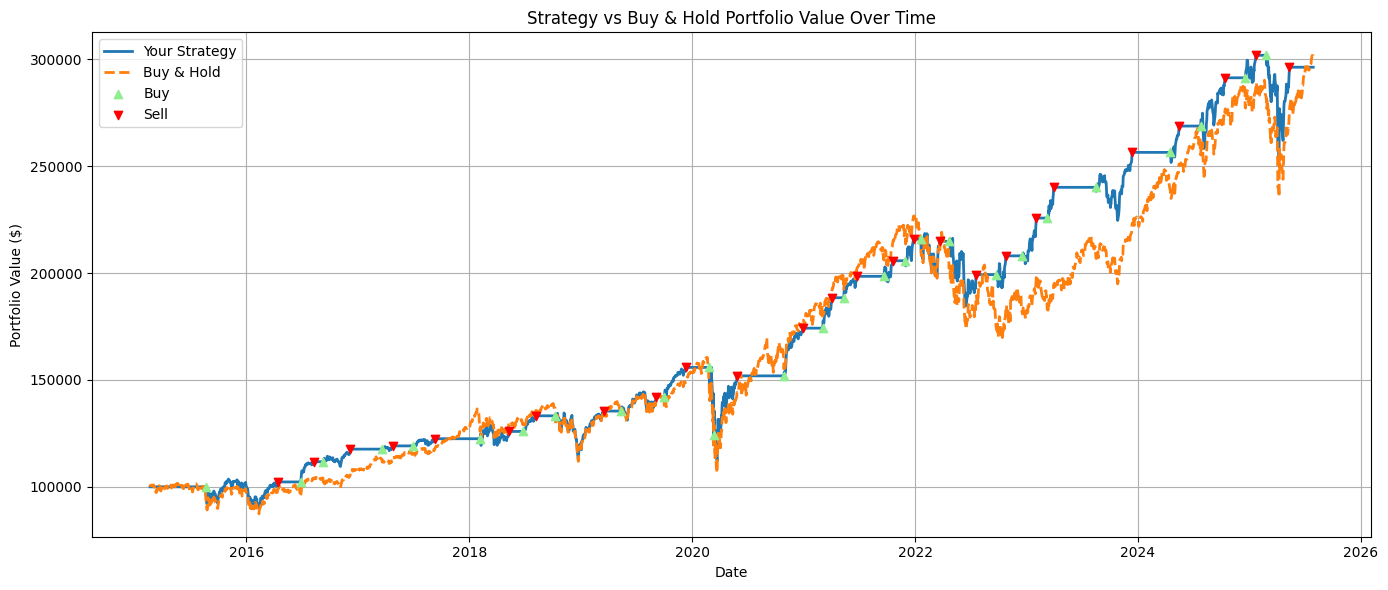

In [38]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.stats import ttest_1samp, norm

def rolling_pval(series, window=30):
    result = []
    for i in range(len(series)):
        if i < window:
            result.append(None)
        else:
            sample = series.iloc[i-window:i]
            tstat, pval = ttest_1samp(sample, series.iloc[i])
            result.append(pval)
    return pd.Series(result, index=series.index)

def simulate_strategy_strict(df, initial_cash=100_000, 
                             buy_threshold=0.5, sell_threshold=0.5, 
                             plateau_buy_threshold=0.1, plateau_sell_threshold=0.1, 
                             buy_gradient_threshold=0.1, sell_gradient_threshold=0.1,
                             zscore_threshold=1.5, pval_threshold=0.05):
    cash = initial_cash
    shares = 0 
    trade_log = []
    skip_log = []

    df = df.copy().dropna(subset=["Close", "Buy Confidence", "Sell Confidence"])
    
    # Rolling stats
    df["Rolling Buy Confidence 7"] = df["Buy Confidence"].rolling(window=7, min_periods=1).mean()
    df["Rolling Buy Confidence 30"] = df["Buy Confidence"].rolling(window=30, min_periods=1).mean()
    df["Rolling Sell Confidence 7"] = df["Sell Confidence"].rolling(window=7, min_periods=1).mean()
    df["Rolling Sell Confidence 30"] = df["Sell Confidence"].rolling(window=30, min_periods=1).mean()

    # Gradients
    df["Buy Gradient"] = df["Rolling Buy Confidence 7"].diff().fillna(0)
    df["Sell Gradient"] = df["Rolling Sell Confidence 7"].diff().fillna(0)
    df["Buy Gradient 7"] = df["Buy Gradient"].rolling(window=7, min_periods=1).mean()
    df["Buy Gradient 30"] = df["Buy Gradient"].rolling(window=30, min_periods=1).mean()
    df["Sell Gradient 7"] = df["Sell Gradient"].rolling(window=7, min_periods=1).mean()
    df["Sell Gradient 30"] = df["Sell Gradient"].rolling(window=30, min_periods=1).mean()

    # Momentum
    df["Buy Momentum"] = df["Buy Confidence"].pct_change(periods=7)
    df["Sell Momentum"] = df["Sell Confidence"].pct_change(periods=7)

    # Z-scores and probabilities
    df["Buy Z"] = (df["Buy Confidence"] - df["Buy Confidence"].rolling(30).mean()) / df["Buy Confidence"].rolling(30).std()
    df["Sell Z"] = (df["Sell Confidence"] - df["Sell Confidence"].rolling(30).mean()) / df["Sell Confidence"].rolling(30).std()
    df["Buy Prob"] = norm.cdf(df["Buy Z"])
    df["Sell Prob"] = norm.cdf(df["Sell Z"])

    # p-values
    df["Buy pval"] = rolling_pval(df["Buy Confidence"])
    df["Sell pval"] = rolling_pval(df["Sell Confidence"])

    for i in range(1, len(df)):
        row = df.iloc[i]
        price = row["Close"]

        zscore_buy_extreme = row["Buy Z"] > zscore_threshold
        pval_buy_significant = row["Buy pval"] < pval_threshold
        zscore_sell_extreme = row["Sell Z"] > zscore_threshold
        pval_sell_significant = row["Sell pval"] < pval_threshold

        # Buy logic
        if row["is_trough"]:
            plateau_buy = row["Buy Gradient 7"] <= row["Buy Gradient 30"] and row["Buy Gradient 7"] <= plateau_buy_threshold and row["Buy Confidence"] >= buy_threshold
            increasing_buy = row["Sell Gradient 7"] >= buy_gradient_threshold

            if (plateau_buy or increasing_buy or zscore_buy_extreme or pval_buy_significant) and row["Buy Confidence"] > -1.0:
                buy_reason = " | ".join([
                    r for cond, r in [
                        (plateau_buy, "Plateau conditions met"),
                        (increasing_buy, "Increasing buy confidence"),
                        (zscore_buy_extreme, "Z-score extreme"),
                        (pval_buy_significant, "p-value significant")
                    ] if cond
                ])
                shares_to_buy = int(cash // price)
                if shares_to_buy > 0:
                    cash -= shares_to_buy * price
                    shares += shares_to_buy
                    trade_log.append((row.name, "BUY", price, shares_to_buy, cash,
                                      row["Buy Confidence"], row["Buy Gradient 7"], buy_reason))
            else:
                skip_log.append((row.name, "BUY", price, shares, cash, row["Buy Confidence"],
                                 row["Buy Gradient 7"], "No buy condition met"))

        # Sell logic
        elif row["is_peak"]:
            plateau_sell = row["Sell Gradient 7"] <= row["Sell Gradient 30"] and row["Sell Gradient 7"] <= plateau_sell_threshold and row["Sell Confidence"] >= sell_threshold
            increasing_sell = row["Buy Gradient 7"] >= sell_gradient_threshold

            if (plateau_sell or increasing_sell or zscore_sell_extreme or pval_sell_significant) and shares > 0 and row["Sell Confidence"] > -1.0:
                sell_reason = " | ".join([
                    r for cond, r in [
                        (plateau_sell, "Plateau conditions met"),
                        (increasing_sell, "Increasing sell confidence"),
                        (zscore_sell_extreme, "Z-score extreme"),
                        (pval_sell_significant, "p-value significant")
                    ] if cond
                ])
                cash += shares * price
                trade_log.append((row.name, "SELL", price, shares, cash,
                                  row["Sell Confidence"], row["Sell Gradient 7"], sell_reason))
                shares = 0
            else:
                skip_log.append((row.name, "SELL", price, shares, cash, row["Sell Confidence"],
                                 row["Sell Gradient 7"], "No sell condition met"))

    final_price = df.iloc[-1]["Close"]
    portfolio_value = cash + shares * final_price

    df_trades = pd.DataFrame(trade_log, columns=[
        "Date", "Action", "Price", "Shares", "Cash", "Buy / Sell Confidence", "Buy / Sell Gradient", "Reason"
    ])
    df_skips = pd.DataFrame(skip_log, columns=[
        "Date", "Action", "Price", "Shares", "Cash", "Buy / Sell Confidence", "Buy / Sell Gradient", "Reason"
    ])

    return portfolio_value, df_trades, df_skips

def compute_portfolio_curve(trade_log, df, initial_cash=100_000):
    """
    Reconstructs portfolio value over time from trade log.
    """
    df = df.copy()
    df["Portfolio Value"] = 0.0 + initial_cash
    shares = 0
    cash = initial_cash
    last_price = df["Close"].iloc[0]

    trade_log = trade_log.set_index("Date")
    trade_log.index = pd.to_datetime(trade_log.index)

    for date, row in df.iterrows():
        if date in trade_log.index:
            trades_today = trade_log.loc[[date]] if isinstance(trade_log.loc[date], pd.Series) else trade_log.loc[date]
            if isinstance(trades_today, pd.DataFrame):
                for _, t in trades_today.iterrows():
                    if t["Action"] == "BUY":
                        shares += t["Shares"]
                        cash = t["Cash"]
                    elif t["Action"] == "SELL":
                        shares = 0
                        cash = t["Cash"]
            else:
                t = trades_today
                if t["Action"] == "BUY":
                    shares += t["Shares"]
                    cash = t["Cash"]
                elif t["Action"] == "SELL":
                    shares = 0
                    cash = t["Cash"]

        last_price = row["Close"]
        df.at[date, "Portfolio Value"] = cash + shares * last_price

    return df["Portfolio Value"]

def compare_strategy_vs_buy_and_hold(df, trade_log, initial_cash=100_000):
    """
    Compares and plots your strategy vs buy-and-hold, with buy/sell markers.
    """
    df = df.copy()
    df.index = pd.to_datetime(df.index)

    # Strategy curve
    strategy_curve = compute_portfolio_curve(trade_log, df, initial_cash)

    # Buy and hold curve
    start_price = df["Close"].iloc[0]
    shares_bought = int(initial_cash // start_price)
    remaining_cash = initial_cash - shares_bought * start_price
    buy_hold_curve = df["Close"] * shares_bought + remaining_cash

    # Extract buy/sell points
    trade_log = trade_log.copy()
    trade_log["Date"] = pd.to_datetime(trade_log["Date"])
    buys = trade_log[trade_log["Action"] == "BUY"]
    sells = trade_log[trade_log["Action"] == "SELL"]

    # Match dates with portfolio values
    buy_dates = buys["Date"]
    sell_dates = sells["Date"]
    buy_values = strategy_curve.loc[buy_dates]
    sell_values = strategy_curve.loc[sell_dates]

    # Plot
    plt.figure(figsize=(14, 6))
    plt.plot(df.index, strategy_curve, label="Your Strategy", linewidth=2)
    plt.plot(df.index, buy_hold_curve, label="Buy & Hold", linewidth=2, linestyle="--")

    # Add buy/sell markers
    plt.scatter(buy_dates, buy_values, marker="^", color="lightgreen", label="Buy", zorder=5)
    plt.scatter(sell_dates, sell_values, marker="v", color="red", label="Sell", zorder=5)

    plt.title("Strategy vs Buy & Hold Portfolio Value Over Time")
    plt.ylabel("Portfolio Value ($)")
    plt.xlabel("Date")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

    return {
        "Strategy Final Value": strategy_curve.iloc[-1],
        "Buy & Hold Final Value": buy_hold_curve.iloc[-1],
        "Difference": strategy_curve.iloc[-1] - buy_hold_curve.iloc[-1]
        }

portfolio_value, trade_log, skip_log = simulate_strategy_strict(df_with_sentiment)
print(f"Final Portfolio Value: ${portfolio_value:,.2f}")

def display_scrollable(df, max_height='300px'):
    html = df.to_html(max_rows=1000)
    styled_html = f"""
    <div style="overflow-y: scroll; max-height: {max_height}; border: 1px solid #ccc">
        {html}
    </div>
    """
    display(HTML(styled_html))

# Usage
portfolio_value, trade_log, skip_log = simulate_strategy_strict(df_with_sentiment, buy_threshold=1.0, sell_threshold=0.7)
display(trade_log)
display_scrollable(skip_log)

summary = compare_strategy_vs_buy_and_hold(df_with_sentiment, trade_log)

Let's try to redefine a strategy, without using arbitrary values. 